## Final Project
### Authors: Naat Ambrosino, Jerrin Redmon
### Version: 1
### Semester: Spring 2022

### Information from Dataset Source (directly pasted from website):
#### Data Set Information:
##### This data set contains some training and testing data from a remote sensing study by Johnson et al. (2013) that involved detecting diseased trees in Quickbird imagery. There are few training samples for the 'diseased trees' class (74) and many for 'other land cover' class (4265).

##### The data set consists of image segments, generated by segmenting the pansharpened image. The segments contain spectral information from the Quickbird multispectral image bands and texture information from the panchromatic (Pan) image band. The testing data set is for the row with â€œSegmentation scale 15â€ segments and â€œoriginal multi-spectral imageâ€ Spectral information in Table 2 of the reference (i.e. row 5). Please see the reference below for more information on the data set, and please cite the reference if you use this data set. Enjoy!

##### Files
##### training.csv: training data set (4339 image segments)
##### testing.csv: testing data set (500 image segments)


#### Attribute Information:

##### class: 'w' (diseased trees), 'n' (all other land cover)
##### GLCM_Pan: GLCM mean texture (Pan band)
##### Mean_G: Mean green value
##### Mean_R: Mean red value
##### Mean_NIR: Mean NIR value (NIR means near infrared)
##### SD_Pan: Standard deviation (Pan band)


### Summary:
#### The dataset was made because some people were trying to detect disesased trees via arial photos (and then making a program that could 'see' the diseased trees in the photos. The data is different aspects of the image(s). 

# WARNING: DO NOT TRY TO RUN ENTIRE NOTEBOOK.
#### Several cells have over 1 minute runtimes.

Importing packages and reading in .csv files

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#Needed this to make deep copies of dataframes
import copy

# Decision Tree model from SKLearn
from sklearn import tree
from sklearn.tree import export_text
import graphviz

# Random Forest model from SKLearn
from sklearn.ensemble import RandomForestClassifier


#Provides a way to split the data into train and test data sets.
from sklearn.model_selection import train_test_split 

#3d plot
from mpl_toolkits import mplot3d

#Provides a way to calculate metrics on the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#### This was taken from the DecisionTree notebook, for ease of plotting confusion matrices. Had to switch y_test and y_pred to be in the correct order, though.

In [3]:
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(5,5))
    heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

In [4]:
dtesting=pd.read_csv("testing.csv")
dtraining=pd.read_csv("training.csv")

#### It seems like the dataset creators preemptively split the data into a training and testing set, just by looking at the CSV files proper and from the description from the site. I am going to combine them back into one dataframe for the exploratory analysis, then take new random samples once we begin the Machine Learning portion.

In [5]:
#dtesting

In [6]:
#dtraining

In [7]:
df=pd.concat([dtesting,dtraining],ignore_index=True,sort=False)

In [8]:
df

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,n,109.828571,183.700000,82.950000,251.750000,16.079412
1,n,130.284483,212.637931,96.896552,482.396552,21.210295
2,n,131.386555,185.466667,85.466667,419.666667,13.339998
3,n,141.345098,180.875000,81.500000,348.062500,18.213577
4,w,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...,...
4834,n,111.568773,203.588235,93.264706,403.735294,26.512777
4835,n,125.435240,206.394161,93.058394,512.270073,33.466060
4836,n,132.123859,465.343750,295.333333,499.250000,38.762967
4837,n,124.469536,215.152632,98.484211,675.915789,28.506542


Later on, some problems were being caused by the column name 'class'. Going to change the name of the 'class' column to 'sick', and change w to 'diseased tree' and n to 'all other land cover', for ease of reference.

In [9]:
#oldcols=df.columns
#oldcols

In [10]:
newcols=['sick', 'GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan']
df.columns=newcols
df.sick.replace('w','diseased tree',inplace=True)
df.sick.replace('n','all other land cover',inplace=True)
df

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,all other land cover,109.828571,183.700000,82.950000,251.750000,16.079412
1,all other land cover,130.284483,212.637931,96.896552,482.396552,21.210295
2,all other land cover,131.386555,185.466667,85.466667,419.666667,13.339998
3,all other land cover,141.345098,180.875000,81.500000,348.062500,18.213577
4,diseased tree,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...,...
4834,all other land cover,111.568773,203.588235,93.264706,403.735294,26.512777
4835,all other land cover,125.435240,206.394161,93.058394,512.270073,33.466060
4836,all other land cover,132.123859,465.343750,295.333333,499.250000,38.762967
4837,all other land cover,124.469536,215.152632,98.484211,675.915789,28.506542


Now to get basic statistical information about the dataset using .describe().

In [11]:
df.iloc[:,1:].describe() #Note, this is before we drop the Triple Major Outlier

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
count,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000
mean,126.855547,231.412658,116.305331,525.800301,24.482007
std,13.450516,63.264941,62.005622,156.579297,10.726997
min,0.000000,117.210526,50.578947,86.500000,0.000000
25%,118.758944,203.896429,91.527009,415.448161,17.679972
50%,127.481872,219.260870,101.631579,518.657143,23.198396
75%,134.947789,239.860577,116.969687,635.133450,29.326445
max,183.281250,1848.916667,1594.583333,1597.333333,156.508431


#### Checking for null values using .info(). Notice that there are 4839 entries, and 4839 non-null entries for each column. Thus, there are no missing values. Next task will be to check for outliers.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4839 entries, 0 to 4838
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sick        4839 non-null   object 
 1   GLCM_pan    4839 non-null   float64
 2   Mean_Green  4839 non-null   float64
 3   Mean_Red    4839 non-null   float64
 4   Mean_NIR    4839 non-null   float64
 5   SD_pan      4839 non-null   float64
dtypes: float64(5), object(1)
memory usage: 227.0+ KB


First, let's use boxplots to look for outliers. sns.boxplot defaults to outliers being 150% of the IQR outside of Q1 and Q3.

<AxesSubplot:>

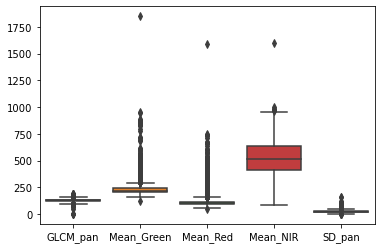

In [13]:
sns.boxplot(data=df)

#### Note that the ranges for GLCM_pan and SD_pan are much smaller than the Means' ranges. Also, more relevantly, note there are a lot of outliers. Going to extend the whiskers so that outliers are 300% of the IQR outside of Q1 and Q3, and see if that changes things much.

<AxesSubplot:>

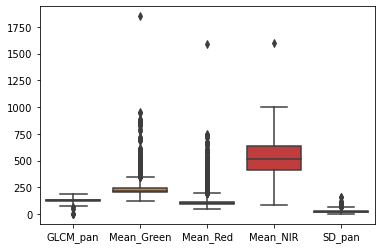

In [14]:
sns.boxplot(data=df, whis=3)

Extending the whiskers did not do much. The values all seem to be very skewed, if not multimodal. (Also, note those 3 points near the top of the chart, far removed from the rest of the data. As we investigate the outliers, we will find that all three of those data points belong to a single entry, index 479, occasionally referred to as the Triple Major Outlier, which will be removed shortly.)

Going to make histograms of the data to look at the distributions of the columns' values before we begin looking at individual outliers, just to get a better idea of whats going on before we start removing entries.

(array([  4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   3.,   4.,   0.,
          5.,  16.,  14.,  24.,  42.,  48.,  90., 140., 242., 387., 478.,
        483., 569., 569., 614., 434., 270., 156.,  93.,  49.,  37.,  19.,
         18.,  13.,   4.,   3.,   1.,   8.]),
 array([  0.      ,   3.665625,   7.33125 ,  10.996875,  14.6625  ,
         18.328125,  21.99375 ,  25.659375,  29.325   ,  32.990625,
         36.65625 ,  40.321875,  43.9875  ,  47.653125,  51.31875 ,
         54.984375,  58.65    ,  62.315625,  65.98125 ,  69.646875,
         73.3125  ,  76.978125,  80.64375 ,  84.309375,  87.975   ,
         91.640625,  95.30625 ,  98.971875, 102.6375  , 106.303125,
        109.96875 , 113.634375, 117.3     , 120.965625, 124.63125 ,
        128.296875, 131.9625  , 135.628125, 139.29375 , 142.959375,
        146.625   , 150.290625, 153.95625 , 157.621875, 161.2875  ,
        164.953125, 168.61875 , 172.284375, 17

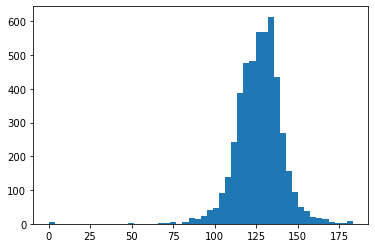

In [15]:
plt.hist(df.GLCM_pan, bins=50)

First, made the histogram of GLCM_pan. It is definitely unimodal, with a slight left skew. Now, going to look closer at the boxplot.

<AxesSubplot:>

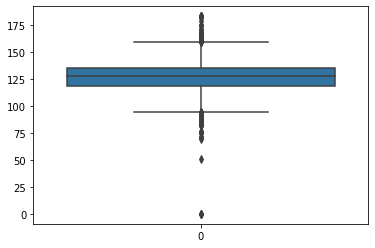

In [16]:
sns.boxplot(data=df.GLCM_pan)

Note how far the values close to 0 are away from all other datapoints. Going to query the dataframe to find out the indices of those, along with the one point around 50.

In [17]:
findGLCMpan=df.query('GLCM_pan<60')
findGLCMpan

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
1482,all other land cover,0.0,450.0,279.0,592.0,0.0
1493,all other land cover,0.0,313.0,207.0,416.0,0.0
1515,all other land cover,0.0,328.0,223.0,384.0,0.0
1545,all other land cover,51.0,346.0,217.0,376.0,0.0
2813,all other land cover,0.0,336.0,190.0,579.0,0.0


Those really far outliers in GLCM_pan are 1482, 1493, 1515, and 2813. Note that for each of those, both GLCM_pan and SD_pan are 0. The less eggrevious value was at GLCM_pan=51, and it is index 1545. Note that SD_pan is 0 for that as well.

Now to look at SD_pan. Going a bit out of order, but SD_pan and GLCM_pan have similar ranges, and their major outliers may be connected. First, histogram.

(array([ 12.,  16., 104., 246., 431., 643., 682., 705., 593., 484., 325.,
        210., 129.,  82.,  52.,  32.,  21.,  14.,   8.,   9.,   4.,   1.,
          6.,   3.,   4.,   6.,   3.,   2.,   1.,   0.,   1.,   1.,   3.,
          3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([  0.        ,   3.13016861,   6.26033723,   9.39050584,
         12.52067446,  15.65084307,  18.78101168,  21.9111803 ,
         25.04134891,  28.17151753,  31.30168614,  34.43185475,
         37.56202337,  40.69219198,  43.8223606 ,  46.95252921,
         50.08269782,  53.21286644,  56.34303505,  59.47320367,
         62.60337228,  65.73354089,  68.86370951,  71.99387812,
         75.12404674,  78.25421535,  81.38438396,  84.51455258,
         87.64472119,  90.77488981,  93.90505842,  97.03522703,
        100.16539565, 103.29556426, 106.42573288, 109.55590149,
        112.6860701 , 115.81623872, 118.94640733, 122.07657595,
        125.206744

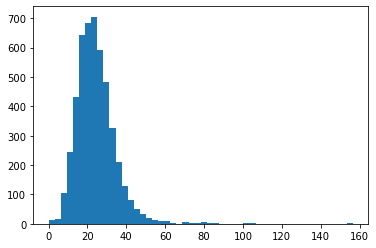

In [18]:
plt.hist(df.SD_pan, bins=50)

Unimodal with a right skew. The values near 0 do not seem to be that eggregious of outliers here, so the outliers we identified before [1482, 1493, 1515, 2813, and to a lesser extent, 1545] are probably major outliers just for GLCM_pan. Now to look at the boxplot.

<AxesSubplot:>

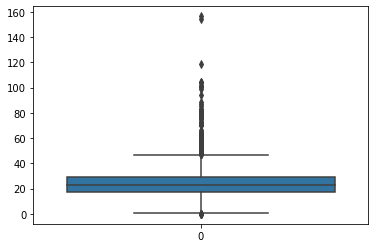

In [19]:
sns.boxplot(data=df.SD_pan)

#### Values around 0 are outliers, but going to check real quick what happens if we extend the whiskers to 175% of IQR outside of Q3 and Q1, instead of 150%.

<AxesSubplot:>

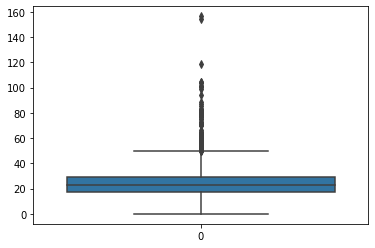

In [20]:
sns.boxplot(data=df.SD_pan,whis=1.75)

Okay, so those values are really not that major of outliers. However, note those values near the top of the plot, above 140, and the other, right around 120. Let's find out what those are.

In [21]:
findSDPanOut=df.query('SD_pan>115')
findSDPanOut

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
3451,all other land cover,104.302083,270.000000,146.0,430.0,154.573248
4466,all other land cover,114.452381,428.047619,278.0,518.0,118.857105
4691,all other land cover,93.979167,543.000000,367.0,396.0,156.508431


The furthest outliers for SD_pan are 3451 and 4691, and the slightly closer one thats still separated is 4466.
Running list of major outliers: [1482, 1493, 1515, 2813, and to a lesser extent, 1545] for GLCM_pan, [3451, 4691, and to a lesser extent, 4466] for SD_pan.
On a positive note, all of the major outliers have been of the 'Not diseased' class (n).

Now to look at Mean_Green in the same way.

(array([1.000e+00, 2.880e+02, 2.247e+03, 1.662e+03, 3.340e+02, 8.700e+01,
        6.900e+01, 4.200e+01, 2.400e+01, 2.100e+01, 2.200e+01, 9.000e+00,
        8.000e+00, 3.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
        0.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 117.2105263 ,  151.84464911,  186.47877193,  221.11289474,
         255.74701756,  290.38114037,  325.01526318,  359.649386  ,
         394.28350881,  428.91763163,  463.55175444,  498.18587725,
         532.82000007,  567.45412288,  602.0882457 ,  636.72236851,
         671.35649132,  705.99061414,  740.62473695,  775.25885977,
         809.89298258,  844.52710539

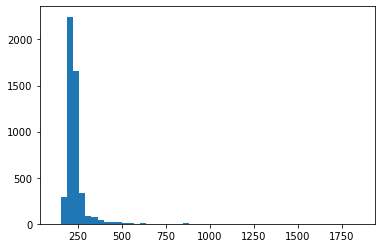

In [22]:
plt.hist(df.Mean_Green, bins=50)

Look how steep that is! The distribution is unimodal, with a right skew.

<AxesSubplot:>

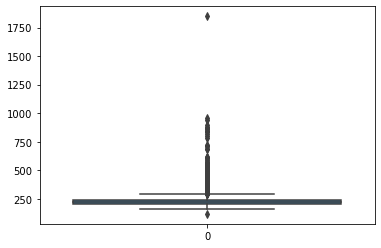

In [23]:
sns.boxplot(data=df.Mean_Green)

Note that really far point. Going to find that first.

In [24]:
findMeanGreenOut=df.query('Mean_Green>1250')
findMeanGreenOut

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,all other land cover,117.109948,1848.916667,1594.583333,1597.333333,16.612412


#### That really far outlier in Mean_Green is 479
 Running list of major outliers: [1482, 1493, 1515, 2813, and to a lesser extent, 1545] for GLCM_pan, [3451, 4691, and to a lesser extent, 4466] for SD_pan, and [479] for Mean_Green. On a positive note, all of the major outliers have been of the 'Not diseased' class (n). Going to check the values of the points with Mean_Green>750, and see how many there are and of what class they are.

In [25]:
MGouts=df.query('Mean_Green>750')
MGouts

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,all other land cover,117.109948,1848.916667,1594.583333,1597.333333,16.612412
1525,all other land cover,123.821429,875.714286,727.571429,943.000000,41.887118
1529,all other land cover,120.015625,857.500000,710.500000,928.000000,28.044607
1530,all other land cover,124.395833,893.333333,746.333333,932.333333,57.434020
1534,all other land cover,96.388889,836.777778,675.111111,877.888889,51.103623
1535,all other land cover,115.378947,819.916667,639.250000,841.000000,46.060573
1549,all other land cover,127.046875,779.000000,601.000000,789.000000,23.413404
1550,all other land cover,121.140625,797.000000,608.000000,819.000000,74.878234
4367,all other land cover,123.446686,846.874286,653.845714,714.468571,30.958788
4381,all other land cover,122.949597,943.451613,736.935484,778.387097,16.664405


In [26]:
len(MGouts)

13

13, all of non-diseased class. None of them have popped up as outliers before. Going to query again, but for Mean_Green>500.

In [27]:
Mouts=df.query('Mean_Green>500')
Mouts

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,all other land cover,117.109948,1848.916667,1594.583333,1597.333333,16.612412
1338,all other land cover,128.025000,559.600000,396.000000,609.800000,23.174124
1339,all other land cover,101.300595,534.809524,398.428571,605.952381,27.311838
1344,all other land cover,117.990991,502.000000,335.000000,560.000000,22.568716
1518,all other land cover,160.894531,609.375000,483.500000,694.937500,27.834051
1525,all other land cover,123.821429,875.714286,727.571429,943.000000,41.887118
1529,all other land cover,120.015625,857.500000,710.500000,928.000000,28.044607
1530,all other land cover,124.395833,893.333333,746.333333,932.333333,57.434020
1531,all other land cover,69.545455,710.000000,579.000000,731.000000,0.000000
1532,all other land cover,120.862500,688.400000,533.400000,706.400000,45.000444


In [28]:
len(Mouts)

41

Going to keep that for later reference and move onto Mean_Red. Note that they are still all non-diseased.

(array([3.210e+02, 2.961e+03, 1.007e+03, 2.130e+02, 9.500e+01, 7.400e+01,
        3.500e+01, 3.500e+01, 2.500e+01, 1.600e+01, 8.000e+00, 8.000e+00,
        6.000e+00, 3.000e+00, 7.000e+00, 5.000e+00, 3.000e+00, 4.000e+00,
        1.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  50.57894737,   81.45903508,  112.3391228 ,  143.21921051,
         174.09929822,  204.97938593,  235.85947365,  266.73956136,
         297.61964907,  328.49973678,  359.3798245 ,  390.25991221,
         421.13999992,  452.02008763,  482.90017535,  513.78026306,
         544.66035077,  575.54043848,  606.4205262 ,  637.30061391,
         668.18070162,  699.06078933

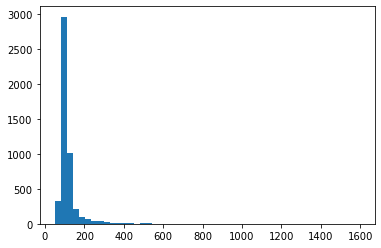

In [29]:
plt.hist(df.Mean_Red, bins=50)

As with Mean_Green, Mean_Red has a very steep unimodal distribution with a right skew.

<AxesSubplot:>

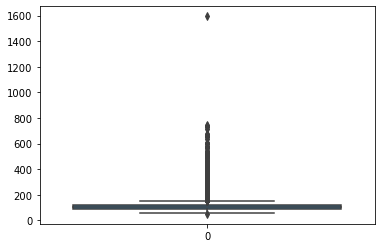

In [30]:
sns.boxplot(data=df.Mean_Red)

Note that very far outlier, near the top. Going to find via a query.

In [31]:
findMeanRedOut=df.query('Mean_Red>1250')
findMeanRedOut

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,all other land cover,117.109948,1848.916667,1594.583333,1597.333333,16.612412


That major outlier in Mean_Red is 479, the same one as the major outlier in Mean_Green. 
Running list of major outliers: [1482, 1493, 1515, 2813, and to a lesser extent, 1545] for GLCM_pan, [3451, 4691, and to a lesser extent, 4466] for SD_pan, and [479] for Mean_Green and Mean_Red. On a positive note, all of the major outliers have been of the 'Not diseased' class (n). Going to find the outliers of Mean_Red with values >400, check classes, and then check if those overlap with the Mean_Green outliers.

In [32]:
MRouts=df.query('Mean_Red>400')
MRouts

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,all other land cover,117.109948,1848.916667,1594.583333,1597.333333,16.612412
1518,all other land cover,160.894531,609.375000,483.500000,694.937500,27.834051
1525,all other land cover,123.821429,875.714286,727.571429,943.000000,41.887118
1529,all other land cover,120.015625,857.500000,710.500000,928.000000,28.044607
1530,all other land cover,124.395833,893.333333,746.333333,932.333333,57.434020
1531,all other land cover,69.545455,710.000000,579.000000,731.000000,0.000000
1532,all other land cover,120.862500,688.400000,533.400000,706.400000,45.000444
1534,all other land cover,96.388889,836.777778,675.111111,877.888889,51.103623
1535,all other land cover,115.378947,819.916667,639.250000,841.000000,46.060573
1536,all other land cover,112.250000,686.000000,528.333333,703.666667,43.774676


#### All non-diseased. Now to check for overlap with the Mean_Green query:

In [33]:
Mouts2=Mouts.query('Mean_Red>400')
Mouts2

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,all other land cover,117.109948,1848.916667,1594.583333,1597.333333,16.612412
1518,all other land cover,160.894531,609.375000,483.500000,694.937500,27.834051
1525,all other land cover,123.821429,875.714286,727.571429,943.000000,41.887118
1529,all other land cover,120.015625,857.500000,710.500000,928.000000,28.044607
1530,all other land cover,124.395833,893.333333,746.333333,932.333333,57.434020
1531,all other land cover,69.545455,710.000000,579.000000,731.000000,0.000000
1532,all other land cover,120.862500,688.400000,533.400000,706.400000,45.000444
1534,all other land cover,96.388889,836.777778,675.111111,877.888889,51.103623
1535,all other land cover,115.378947,819.916667,639.250000,841.000000,46.060573
1536,all other land cover,112.250000,686.000000,528.333333,703.666667,43.774676


In [34]:
len(Mouts)

41

In [35]:
len(Mouts2)

30

11 of those did not overlap, but 30 did. Keeping in mind for future reference and moving onto Mean_NIR.

(array([  3.,   5.,  18.,  33.,  67.,  93., 111., 148., 228., 249., 297.,
        365., 360., 328., 345., 318., 332., 288., 257., 238., 183., 167.,
        135., 104.,  57.,  46.,  31.,  22.,   5.,   4.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  86.5       ,  116.71666666,  146.93333332,  177.14999998,
         207.36666664,  237.5833333 ,  267.79999996,  298.01666662,
         328.23333328,  358.44999994,  388.6666666 ,  418.88333326,
         449.09999992,  479.31666658,  509.53333324,  539.7499999 ,
         569.96666656,  600.18333322,  630.39999988,  660.61666654,
         690.8333332 ,  721.04999986,  751.26666652,  781.48333318,
         811.69999984,  841.9166665 ,  872.13333316,  902.34999982,
         932.56666648,  962.78333314,  992.9999998 , 1023.21666646,
        1053.43333312, 1083.64999978, 1113.86666644, 1144.0833331 ,
        1174.29999976, 1204.51666642, 1234.733

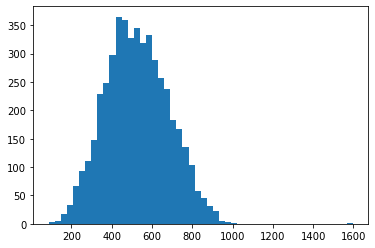

In [36]:
plt.hist(df.Mean_NIR, bins=50)

Mean_NIR has a much different distribution than Mean_Green and Mean_Red did. It may still have a right skew, but that could just be a complete outlier.

<AxesSubplot:>

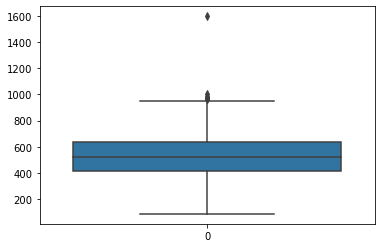

In [37]:
sns.boxplot(data=df.Mean_NIR)

Mean_NIR's 'skew' seems to be mostly a single value near the top of the plot. Going to check its index.

In [38]:
findMeanNIROut=df.query('Mean_NIR>1250')
findMeanNIROut

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,all other land cover,117.109948,1848.916667,1594.583333,1597.333333,16.612412


The really far outlier was 479, again.  Running list of major outliers: [1482, 1493, 1515, 2813, and to a lesser extent, 1545] for GLCM_pan, [3451, 4691, and to a lesser extent, 4466] for SD_pan, and [479] for Mean_Green, Mean_Red, Mean_NIR. On a positive note, all of the major outliers have been of the 'Not diseased' class (n) Very good case for dropping 479. We're going to tenatively keep the observations in Mouts2, as they do not seem to be major outliers of any other column. 

Since index 479 is an extreme outlier in three different columns, and is of the "not diseased" class (n) which has over 4000 entries, if we kept it in it would have a slight chance of giving the model a slight benefit (since it is just one point out of >4000), and due to its nature as an extreme outlier in several ways, would also have a high chance of causing problems within the model. It's likely some kind of white/yellow, high-heat surface-- like a mirror, or a piece of metal, or perhaps a fire. So, we are going to drop it.

In [39]:
df

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,all other land cover,109.828571,183.700000,82.950000,251.750000,16.079412
1,all other land cover,130.284483,212.637931,96.896552,482.396552,21.210295
2,all other land cover,131.386555,185.466667,85.466667,419.666667,13.339998
3,all other land cover,141.345098,180.875000,81.500000,348.062500,18.213577
4,diseased tree,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...,...
4834,all other land cover,111.568773,203.588235,93.264706,403.735294,26.512777
4835,all other land cover,125.435240,206.394161,93.058394,512.270073,33.466060
4836,all other land cover,132.123859,465.343750,295.333333,499.250000,38.762967
4837,all other land cover,124.469536,215.152632,98.484211,675.915789,28.506542


In [40]:
df.iloc[479]

sick          all other land cover
GLCM_pan                117.109948
Mean_Green             1848.916667
Mean_Red               1594.583333
Mean_NIR               1597.333333
SD_pan                   16.612412
Name: 479, dtype: object

In [41]:
df.drop([479],inplace=True)

In [42]:
df

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,all other land cover,109.828571,183.700000,82.950000,251.750000,16.079412
1,all other land cover,130.284483,212.637931,96.896552,482.396552,21.210295
2,all other land cover,131.386555,185.466667,85.466667,419.666667,13.339998
3,all other land cover,141.345098,180.875000,81.500000,348.062500,18.213577
4,diseased tree,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...,...
4834,all other land cover,111.568773,203.588235,93.264706,403.735294,26.512777
4835,all other land cover,125.435240,206.394161,93.058394,512.270073,33.466060
4836,all other land cover,132.123859,465.343750,295.333333,499.250000,38.762967
4837,all other land cover,124.469536,215.152632,98.484211,675.915789,28.506542


Note that there are now only 4838 observations.

Now, to redo some of those visualizations and summaries now that 479 is gone.

<AxesSubplot:>

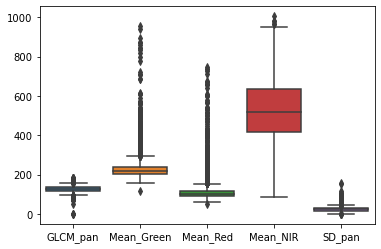

In [43]:
sns.boxplot(data=df.iloc[:,1:])

Making another boxplot of all the data (without 479), except with the data having been normalized:

In [44]:
df.head()

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,all other land cover,109.828571,183.700000,82.950000,251.750000,16.079412
1,all other land cover,130.284483,212.637931,96.896552,482.396552,21.210295
2,all other land cover,131.386555,185.466667,85.466667,419.666667,13.339998
3,all other land cover,141.345098,180.875000,81.500000,348.062500,18.213577
4,diseased tree,121.383408,218.357143,112.017857,426.607143,19.083196


In [45]:
dfN=(df.iloc[:,1:]-df.iloc[:,1:].min())/(df.iloc[:,1:].max()-df.iloc[:,1:].min())

In [46]:
dfN.head()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,0.599235,0.079295,0.046527,0.179812,0.102738
1,0.710845,0.113807,0.066572,0.430783,0.135522
2,0.716858,0.081402,0.050144,0.362525,0.085235
3,0.771192,0.075926,0.044442,0.284611,0.116374
4,0.662279,0.120628,0.088305,0.370077,0.121931


Adding back in sick column:

In [47]:
dfN['sick']=df.sick

In [48]:
dfN

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan,sick
0,0.599235,0.079295,0.046527,0.179812,0.102738,all other land cover
1,0.710845,0.113807,0.066572,0.430783,0.135522,all other land cover
2,0.716858,0.081402,0.050144,0.362525,0.085235,all other land cover
3,0.771192,0.075926,0.044442,0.284611,0.116374,all other land cover
4,0.662279,0.120628,0.088305,0.370077,0.121931,diseased tree
...,...,...,...,...,...,...
4834,0.608730,0.103014,0.061352,0.345190,0.169402,all other land cover
4835,0.684387,0.106360,0.061055,0.463289,0.213829,all other land cover
4836,0.720880,0.415184,0.351783,0.449122,0.247673,all other land cover
4837,0.679118,0.116806,0.068854,0.641355,0.182141,all other land cover


Boxplot of normalized data (without 479)

<AxesSubplot:>

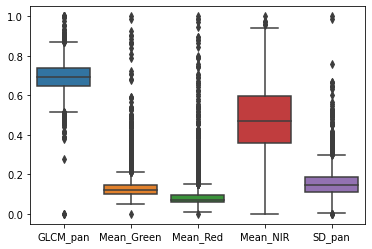

In [49]:
sns.boxplot(data=dfN.iloc[:,:-1])

<AxesSubplot:>

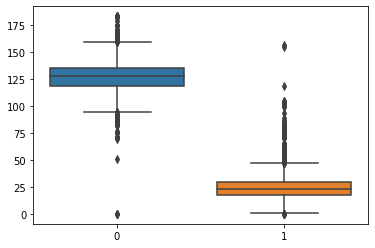

In [50]:
sns.boxplot(data=[df.GLCM_pan,df.SD_pan])

<AxesSubplot:>

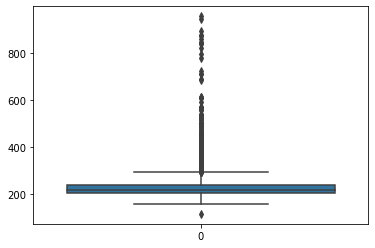

In [51]:
sns.boxplot(data=df.Mean_Green)

<AxesSubplot:>

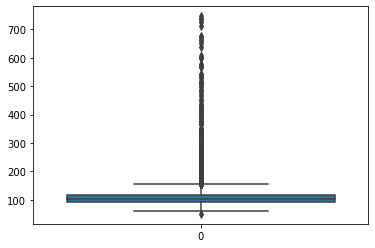

In [52]:
sns.boxplot(data=df.Mean_Red)

<AxesSubplot:>

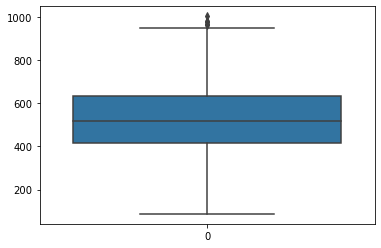

In [53]:
sns.boxplot(data=df.Mean_NIR)

(array([1.000e+00, 0.000e+00, 1.700e+01, 2.120e+02, 7.610e+02, 1.317e+03,
        1.058e+03, 7.090e+02, 3.190e+02, 1.140e+02, 5.700e+01, 4.000e+01,
        4.700e+01, 2.400e+01, 3.000e+01, 1.900e+01, 9.000e+00, 1.500e+01,
        8.000e+00, 1.500e+01, 1.100e+01, 3.000e+00, 1.400e+01, 2.000e+00,
        7.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([117.2105263 , 133.98060149, 150.75067668, 167.52075186,
        184.29082705, 201.06090224, 217.83097743, 234.60105262,
        251.3711278 , 268.14120299, 284.91127818, 301.68135337,
        318.45142856, 335.22150374, 351.99157893, 368.76165412,
        385.53172931, 402.3018045 , 419.07187968, 435.84195487,
        452.61203006, 469.38210525, 486.15218044, 502.92

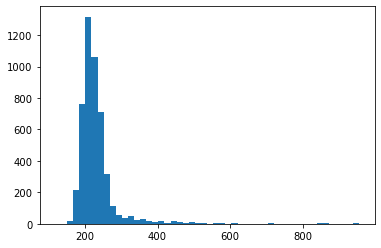

In [54]:
plt.hist(df.Mean_Green, bins=50)

(array([2.000e+00, 1.820e+02, 1.121e+03, 1.533e+03, 9.660e+02, 3.860e+02,
        1.610e+02, 1.020e+02, 5.500e+01, 4.500e+01, 3.800e+01, 4.300e+01,
        2.700e+01, 2.100e+01, 1.400e+01, 2.100e+01, 1.300e+01, 1.300e+01,
        1.300e+01, 1.000e+01, 1.100e+01, 5.000e+00, 5.000e+00, 2.000e+00,
        5.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 4.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00]),
 array([ 50.57894737,  64.49403509,  78.40912281,  92.32421053,
        106.23929824, 120.15438596, 134.06947368, 147.9845614 ,
        161.89964912, 175.81473684, 189.72982456, 203.64491227,
        217.55999999, 231.47508771, 245.39017543, 259.30526315,
        273.22035087, 287.13543859, 301.0505263 , 314.96561402,
        328.88070174, 342.79578946, 356.71087718, 370.62

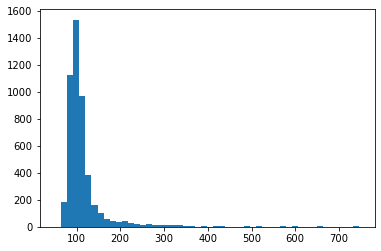

In [55]:
plt.hist(df.Mean_Red, bins=50)

(array([  1.,   2.,   3.,  10.,  11.,  18.,  31.,  42.,  54.,  59.,  61.,
         81.,  97., 137., 130., 143., 184., 170., 212., 234., 215., 201.,
        208., 212., 185., 196., 202., 209., 177., 169., 158., 148., 136.,
        107., 115., 102.,  88.,  71.,  67.,  51.,  29.,  34.,  22.,  21.,
          9.,  15.,   5.,   3.,   2.,   1.]),
 array([  86.5       ,  104.88032258,  123.26064516,  141.64096774,
         160.02129032,  178.4016129 ,  196.78193548,  215.16225806,
         233.54258064,  251.92290322,  270.3032258 ,  288.68354838,
         307.06387096,  325.44419354,  343.82451612,  362.2048387 ,
         380.58516128,  398.96548386,  417.34580644,  435.72612902,
         454.1064516 ,  472.48677418,  490.86709676,  509.24741934,
         527.62774192,  546.0080645 ,  564.38838708,  582.76870966,
         601.14903224,  619.52935482,  637.9096774 ,  656.28999998,
         674.67032256,  693.05064514,  711.43096772,  729.8112903 ,
         748.19161288,  766.57193546,  784.952

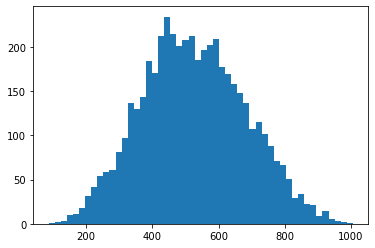

In [56]:
plt.hist(df.Mean_NIR, bins=50)

Going to run an SNS pairplot to see how the values vary by class, which could help us determine what models may be most effective.

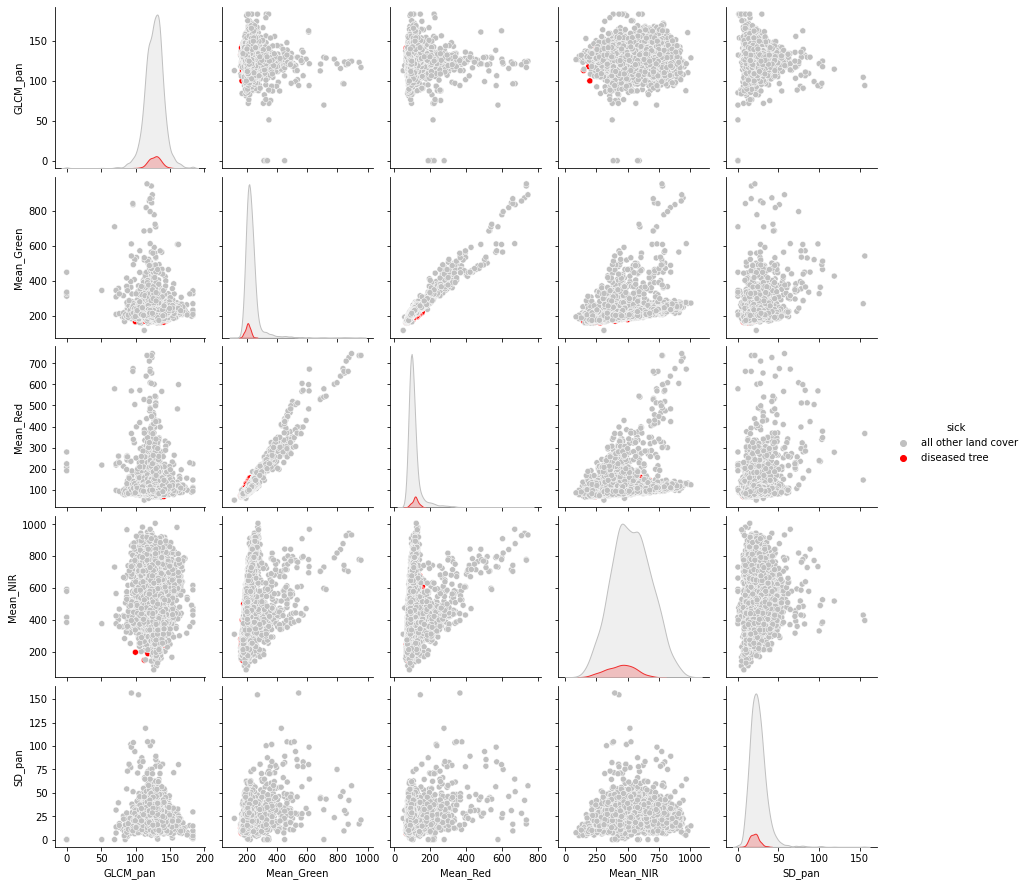

In [57]:
sns.pairplot(df[['GLCM_pan','Mean_Green','Mean_Red','Mean_NIR','SD_pan','sick']], hue='sick', palette={'diseased tree':'red','all other land cover':'silver'})

Something that may pose a big of a problem-- the 'not' observations' values seem to envelop the 'sickTree' observations' values in most of these pairplots. Going to look at the Means together, and then going to see what these pairplots look like with just the 'sickTree' class observations (and then perhaps some more visualizations of that class.) Though, the 'Radial basis' function may help with that-- if we can figure out how it works and how to use it.

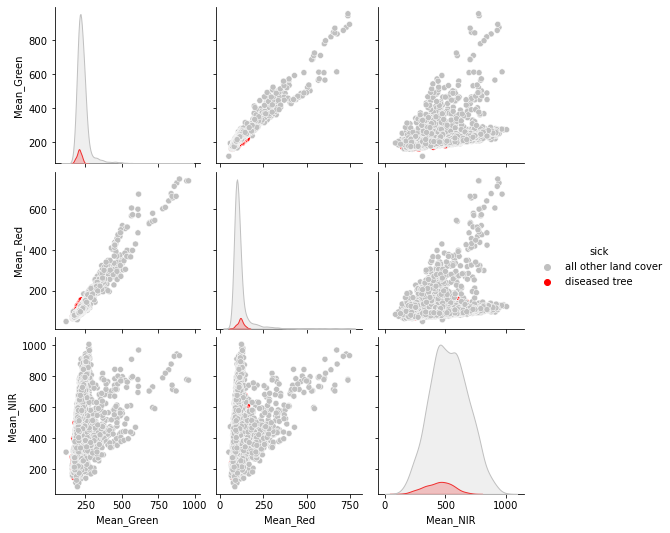

In [58]:
sns.pairplot(df[['Mean_Green','Mean_Red','Mean_NIR','sick']], hue='sick',palette={'diseased tree':'red','all other land cover':'silver'})

In [59]:
dfSick=df.query('sick=="diseased tree"')
dfSick

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
4,diseased tree,121.383408,218.357143,112.017857,426.607143,19.083196
6,diseased tree,124.010204,215.594595,117.027027,477.297297,24.574628
7,diseased tree,125.608407,209.649123,121.228070,443.280702,25.757314
16,diseased tree,116.948953,214.562500,127.750000,390.208333,23.070506
17,diseased tree,116.948953,214.562500,127.750000,390.208333,23.070506
...,...,...,...,...,...,...
569,diseased tree,141.574230,199.244444,127.333333,364.177778,15.219286
570,diseased tree,127.218812,190.314961,110.102362,383.393701,19.666454
571,diseased tree,118.122585,217.894118,134.235294,443.111765,18.376031
572,diseased tree,138.614314,213.603175,126.111111,421.000000,18.304925


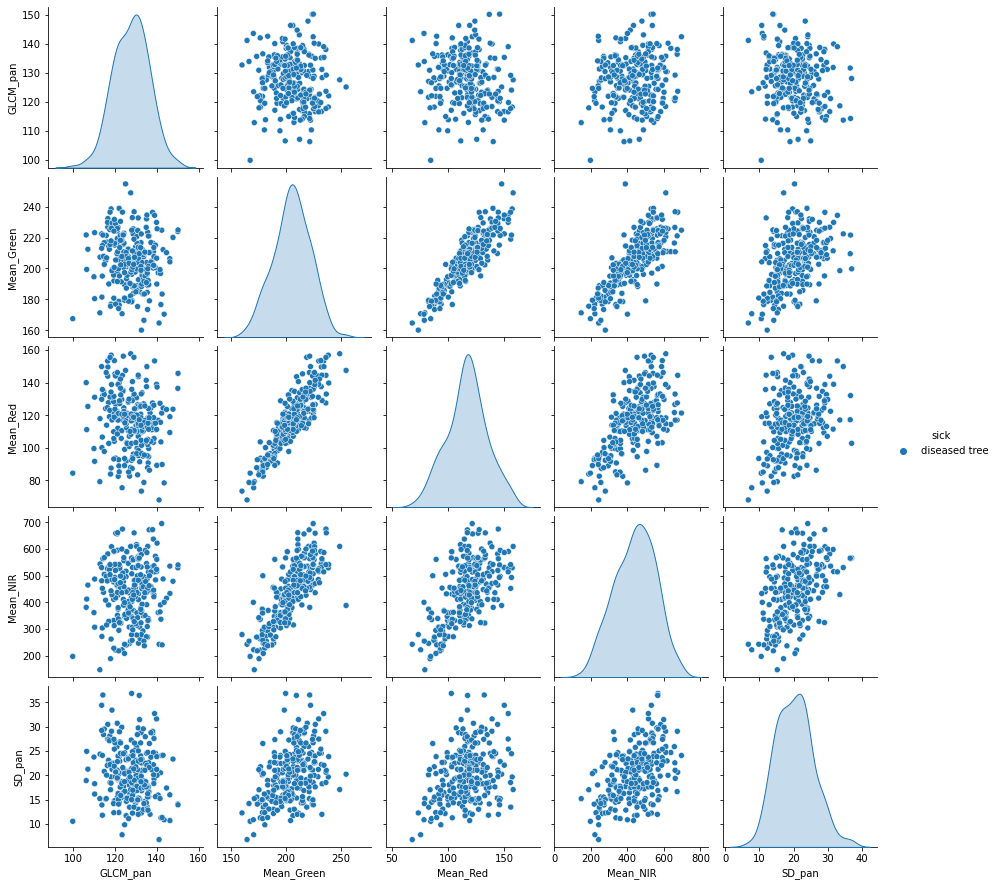

In [60]:
sns.pairplot(dfSick[['GLCM_pan','Mean_Green','Mean_Red','Mean_NIR','SD_pan','sick']], hue='sick')

It may be worth looking into some of the differences between the full dataset, the sickTree observations, and the not observations. Going to do so.

In [61]:
dfNot=df.query('sick=="all other land cover"')
dfNot

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,all other land cover,109.828571,183.700000,82.950000,251.750000,16.079412
1,all other land cover,130.284483,212.637931,96.896552,482.396552,21.210295
2,all other land cover,131.386555,185.466667,85.466667,419.666667,13.339998
3,all other land cover,141.345098,180.875000,81.500000,348.062500,18.213577
5,all other land cover,122.757576,205.960000,86.760000,407.680000,17.823580
...,...,...,...,...,...,...
4834,all other land cover,111.568773,203.588235,93.264706,403.735294,26.512777
4835,all other land cover,125.435240,206.394161,93.058394,512.270073,33.466060
4836,all other land cover,132.123859,465.343750,295.333333,499.250000,38.762967
4837,all other land cover,124.469536,215.152632,98.484211,675.915789,28.506542


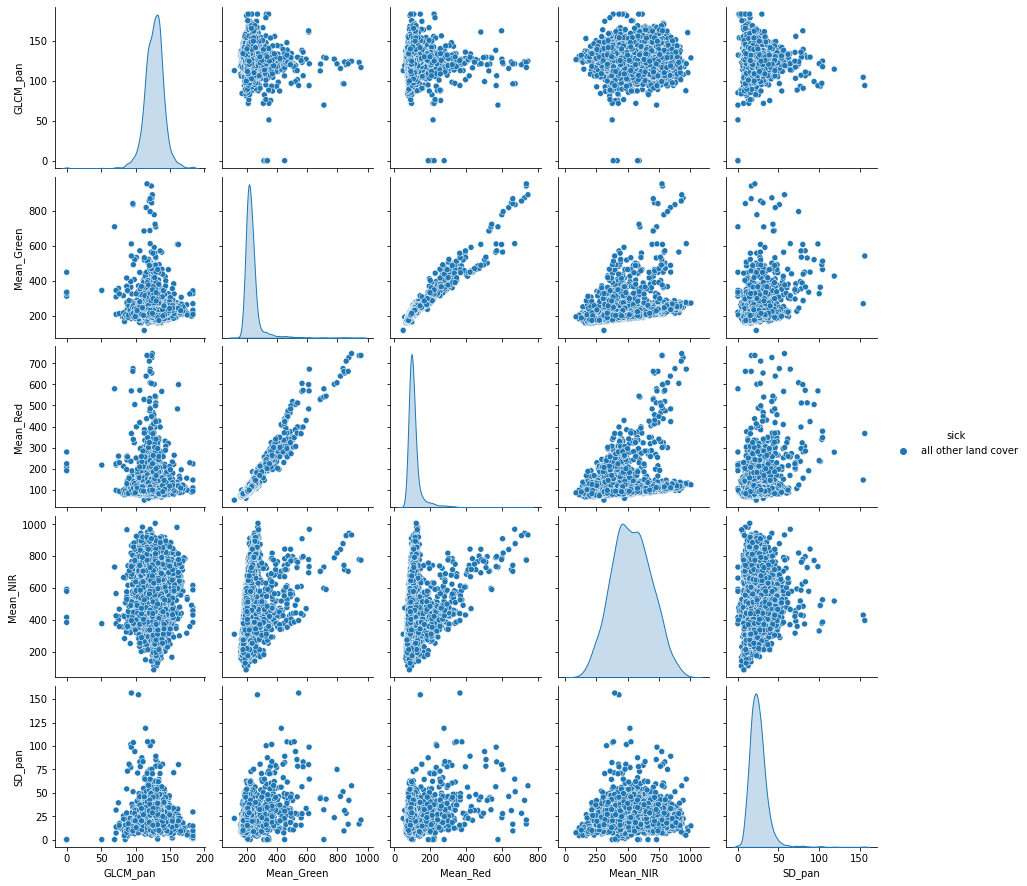

In [62]:
sns.pairplot(dfNot[['GLCM_pan','Mean_Green','Mean_Red','Mean_NIR','SD_pan','sick']], hue='sick')

In [63]:
df.iloc[:,1:].describe()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
count,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000
mean,126.857561,231.078325,115.999776,525.578818,24.483634
std,13.451176,58.841068,58.254692,155.835557,10.727509
min,0.000000,117.210526,50.578947,86.500000,0.000000
25%,118.776184,203.894643,91.521466,415.441472,17.684386
50%,127.482533,219.260870,101.629515,518.495238,23.198874
75%,134.947889,239.846154,116.963268,635.111538,29.328327
max,183.281250,955.714286,746.333333,1005.516129,156.508431


In [64]:
dfNot.iloc[:,1:].describe()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
count,4577.000000,4577.000000,4577.000000,4577.000000,4577.000000
mean,126.809874,232.549245,115.968808,530.396381,24.721706
std,13.679032,60.031244,59.743093,156.645516,10.904041
min,0.000000,117.210526,50.578947,86.500000,0.000000
25%,118.536023,204.714286,91.250000,418.494382,17.804016
50%,127.437819,220.555556,100.684211,524.729730,23.406588
75%,135.059289,241.333333,115.833333,641.102041,29.677077
max,183.281250,955.714286,746.333333,1005.516129,156.508431


As expected (since the vast majority of the observations are of the 'all other land cover' class), when there are differences in the basic statistics of the full dataset and the dataset that only has observations that are not diseased trees, they are very minor (ignoring count, of course.)

In [65]:
dfSick.iloc[:,1:].describe()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
count,261.000000,261.000000,261.000000,261.000000,261.000000
mean,127.693820,205.283692,116.542842,441.096116,20.308693
std,8.490524,16.719662,17.756550,111.131804,5.460654
min,99.812500,160.029412,68.000000,146.777778,6.753471
25%,121.506731,195.055556,105.208333,361.321429,15.973489
50%,128.216868,205.557252,117.000000,448.071429,20.139100
75%,133.532538,216.500000,127.333333,527.258621,23.747187
max,150.181035,254.812500,157.722772,695.750000,36.859319


##### For the dataset of sick trees, most of the basic statistics are far off from the full dataset and the dfNot dataframe. 
##### The mean of GLCM_pan is strickingly similar across all the datasets, and so is the mean of Mean_Red. The rest of the columns of dfSick have noticably different mean values from df and dfNot.
##### Although all of the columns of dfSick have noticeably different standard deviations from the other two dataframes, it is worth noting just how different the standard deviations for Mean_Green and Mean_Red are-- from about 60 t0 ~17, and from about 59 to ~18. This is especially noteable as Mean_Red's mean was not that different between the three datasets.
##### The minimum values, as expected, changed. GLCM_pan changed the most drastically, but that was expected from our earlier investigation of GLCM_pan's outlier values.
##### Mean_NIR has a very dramatic difference for quartile values when comparing dfSick to the others-- Q1 goes from ~416 to 361, Q2 goes from ~520 to 448, and Q3 goes from ~640 to 527 (with the first value being approximately the values for df and dfNot, and the second values being dfSick)
##### The maximum values also had a significant shift-- not surprising, given our earlier investigation of outliers. 

<AxesSubplot:>

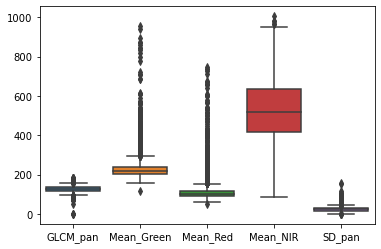

In [66]:
sns.boxplot(data=df)

<AxesSubplot:>

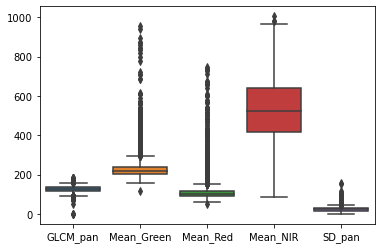

In [67]:
sns.boxplot(data=dfNot)

Barely any change from df to dfNot, as expected.

<AxesSubplot:>

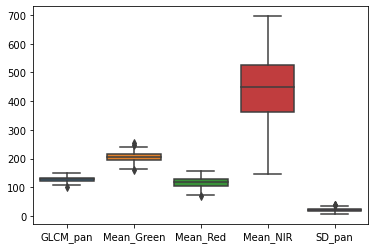

In [68]:
sns.boxplot(data=dfSick)

As expected, a major difference between the other two and dfSick. Going to look at each of these in closer detail.

Having some trouble with getting a boxplot of dfSick.GLCM_pan, though I am not getting any errors for dfNot and df. plt.boxplot works, however.

In [69]:
#sns.boxplot(data=dfSick.GLCM_pan)

<AxesSubplot:ylabel='Value'>

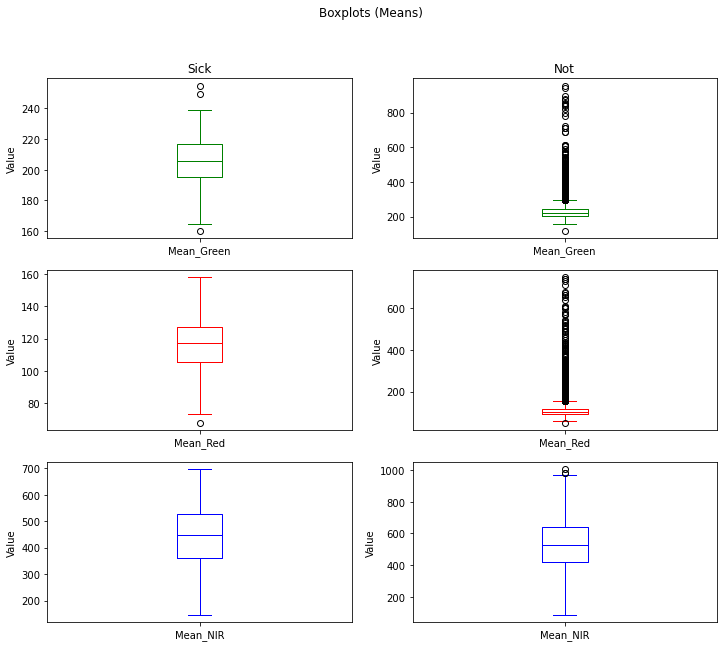

In [70]:
fig, axes = plt.subplots(3,2, figsize=(12,10))
fig.suptitle('Boxplots (Means)')
dfSick.Mean_Green.plot(kind='box',xlabel='Mean_Green',ylabel='Value', title='Sick',color='green',legend=False,ax=axes[0,0])
dfNot.Mean_Green.plot(kind='box',xlabel='Mean_Green',ylabel='Value',title='Not',color='green',legend=False,ax=axes[0,1])
dfSick.Mean_Red.plot(kind='box',xlabel='Mean_Red',ylabel='Value',color='red',legend=False,ax=axes[1,0])
dfNot.Mean_Red.plot(kind='box',xlabel='Mean_Red',ylabel='Value',color='red',legend=False,ax=axes[1,1])
dfSick.Mean_NIR.plot(kind='box',xlabel='Mean_NIR',ylabel='Value',color='blue',legend=False,ax=axes[2,0])
dfNot.Mean_NIR.plot(kind='box',xlabel='Mean_NIR',ylabel='Value',color='blue',legend=False,ax=axes[2,1])

<AxesSubplot:ylabel='Value'>

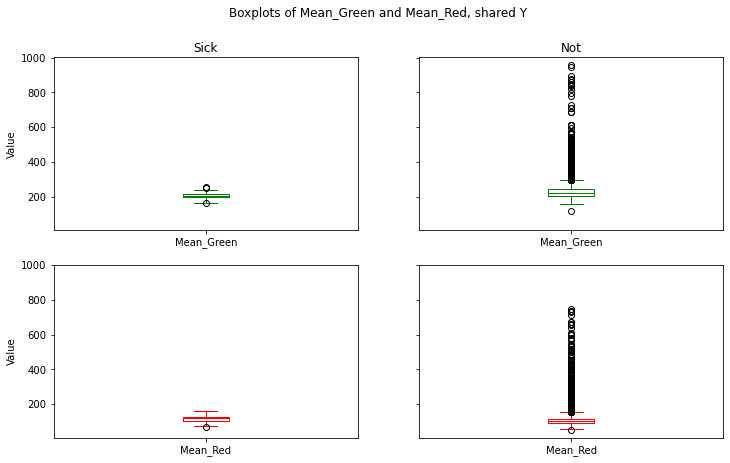

In [71]:
fig, axes = plt.subplots(2,2, figsize=(12,7),sharey=True)
fig.suptitle('Boxplots of Mean_Green and Mean_Red, shared Y')
dfSick.Mean_Green.plot(kind='box',xlabel='Mean_Green',ylabel='Value', title='Sick',color='green',legend=False,ax=axes[0,0])
dfNot.Mean_Green.plot(kind='box',xlabel='Mean_Green',ylabel='Value',title='Not',color='green',legend=False,ax=axes[0,1])
dfSick.Mean_Red.plot(kind='box',xlabel='Mean_Red',ylabel='Value',color='red',legend=False,ax=axes[1,0])
dfNot.Mean_Red.plot(kind='box',xlabel='Mean_Red',ylabel='Value',color='red',legend=False,ax=axes[1,1])

<AxesSubplot:title={'center':'Not'}, ylabel='Value'>

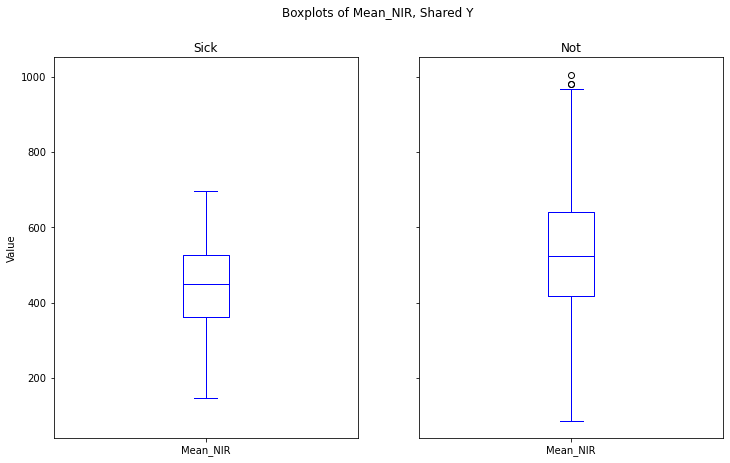

In [72]:
fig, axes = plt.subplots(1,2, figsize=(12,7),sharey=True)
fig.suptitle('Boxplots of Mean_NIR, Shared Y')
dfSick.Mean_NIR.plot(kind='box',xlabel='Mean_NIR',ylabel='Value',color='blue',title='Sick',legend=False,ax=axes[0])
dfNot.Mean_NIR.plot(kind='box',xlabel='Mean_NIR',ylabel='Value',color='blue',title='Not',legend=False,ax=axes[1])

## Start of full data cleaning

First, going to make a second dataset, without all of those major outliers from earlier, and call it df2. First, find what cut offs we want to use to query.

## Clean data set = dfB

In [73]:
dfB=df.copy(deep=True)

<AxesSubplot:title={'center':'Histogram'}, ylabel='Frequency'>

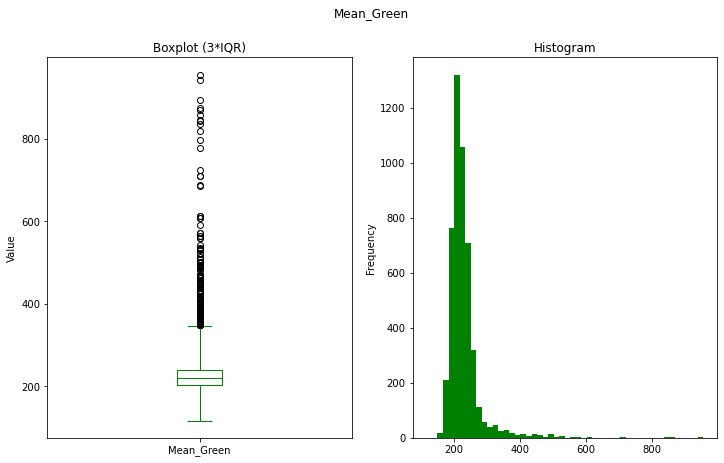

In [74]:
fig, axes = plt.subplots(1,2, figsize=(12,7))
fig.suptitle('Mean_Green')
df.Mean_Green.plot(kind='box',ylabel='Value', title='Boxplot (3*IQR)',color='green',whis=3,legend=False,ax=axes[0])
df.Mean_Green.plot(kind='hist',title='Histogram',color='green',bins=50,legend=False,ax=axes[1])

Now, using quartiles, I'm going to find outliers. I'm going to use 300% of the IQR instead of the typical 150%, as I only want to remove major outliers. I'm going to make a function to find these for me.

In [75]:
def findingOuts(colName):
    q1=np.percentile(df[colName], 25)
    q3=np.percentile(df[colName], 75)
    iqr=q3-q1
    upcut=(3*iqr)+q3
    lowcut=q1-(3*iqr)
    List=[upcut,lowcut]
    return List

In [76]:
tempG=copy.deepcopy(findingOuts('Mean_Green'))
upcutG,lowcutG=tempG
df.query('Mean_Green>@upcutG or Mean_Green<@lowcutG').sick.groupby(df.query('Mean_Green>@upcutG or Mean_Green<@lowcutG').sick).count()

sick
all other land cover    167
Name: sick, dtype: int64

All of those outliers were from the 'all other land cover' class. That's good. Will soon remove those. Going to continue with other columns, but first, going to check maximums of the sick observations, so we can check we aren't getting too close to their values.

In [77]:
upcutG

347.70068672499997

In [78]:
df.query('sick=="diseased tree"').Mean_Green.max()

254.8125

The upper bound of Mean_Red I found was about 347, so the data we plan to remove is still relatively far off. Good to continue.

<AxesSubplot:title={'center':'Histogram'}, ylabel='Frequency'>

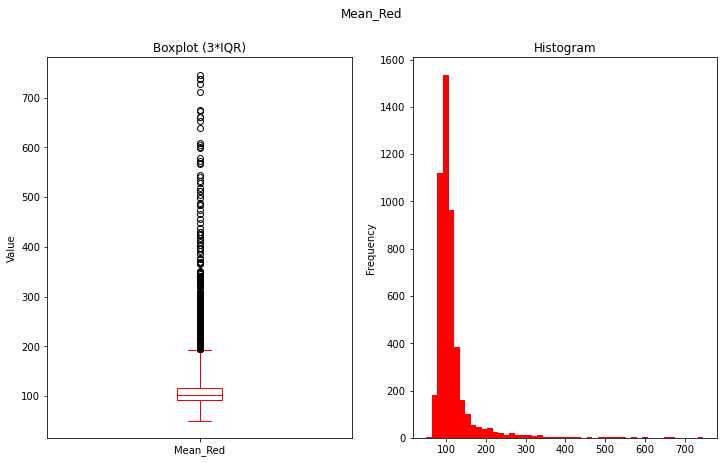

In [79]:
fig, axes = plt.subplots(1,2, figsize=(12,7))
fig.suptitle('Mean_Red')
df.Mean_Red.plot(kind='box',ylabel='Value', title='Boxplot (3*IQR)',color='red',whis=3,legend=False,ax=axes[0])
df.Mean_Red.plot(kind='hist',title='Histogram',color='red',bins=50,legend=False,ax=axes[1])

In [80]:
tempR=copy.deepcopy(findingOuts('Mean_Red'))
upcutR,lowcutR=tempR
df.query('Mean_Red>@upcutR or Mean_Red<@lowcutR').sick.groupby(df.query('Mean_Red>@upcutR or Mean_Red<@lowcutR').sick).count()

sick
all other land cover    273
Name: sick, dtype: int64

In [81]:
upcutR

193.28867383750003

In [82]:
df.query('sick=="diseased tree"').Mean_Red.max()

157.7227723

Upper bound is far enough from max of the sick Mean_Reds that I think we're fine.

<AxesSubplot:title={'center':'Histogram'}, ylabel='Frequency'>

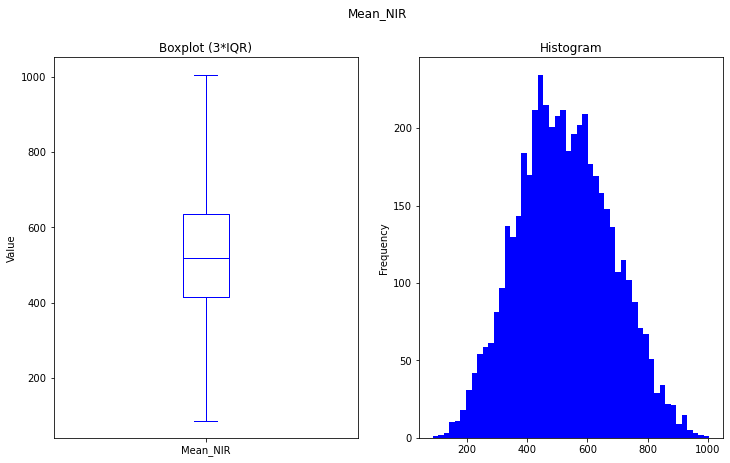

In [83]:
fig, axes = plt.subplots(1,2, figsize=(12,7))
fig.suptitle('Mean_NIR')
df.Mean_NIR.plot(kind='box',ylabel='Value', title='Boxplot (3*IQR)',color='blue',whis=3,legend=False,ax=axes[0])
df.Mean_NIR.plot(kind='hist',title='Histogram',color='blue',bins=50,legend=False,ax=axes[1])

No major outliers. Moving on.

<AxesSubplot:title={'center':'Histogram'}, ylabel='Frequency'>

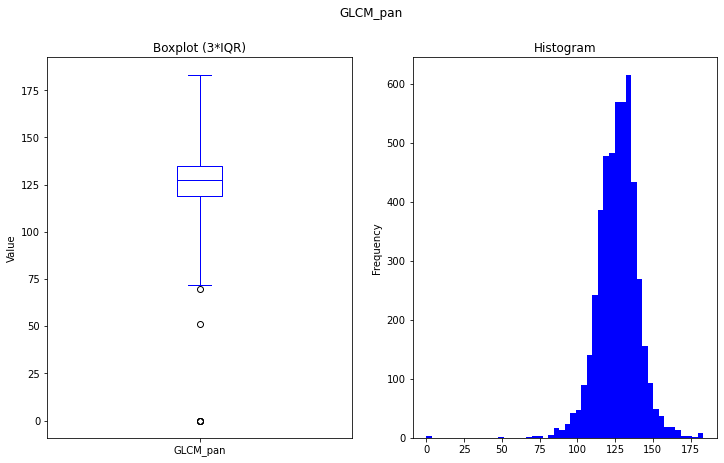

In [84]:
fig, axes = plt.subplots(1,2, figsize=(12,7))
fig.suptitle('GLCM_pan')
df.GLCM_pan.plot(kind='box',ylabel='Value', title='Boxplot (3*IQR)',color='blue',whis=3,legend=False,ax=axes[0])
df.GLCM_pan.plot(kind='hist',title='Histogram',color='blue',bins=50,legend=False,ax=axes[1])

In [85]:
temp1=copy.deepcopy(findingOuts('GLCM_pan'))
upcutGL,lowcutGL=temp1
df.query('GLCM_pan>@upcutGL or GLCM_pan<@lowcutGL').sick.groupby(df.query('GLCM_pan>@upcutGL or GLCM_pan<@lowcutGL').sick).count()

sick
all other land cover    6
Name: sick, dtype: int64

In [86]:
lowcutGL

70.26106815000003

In [87]:
df.query('sick=="diseased tree"').GLCM_pan.min()

99.8125

That's a little close, but still far enough off that we should be fine.

<AxesSubplot:title={'center':'Histogram'}, ylabel='Frequency'>

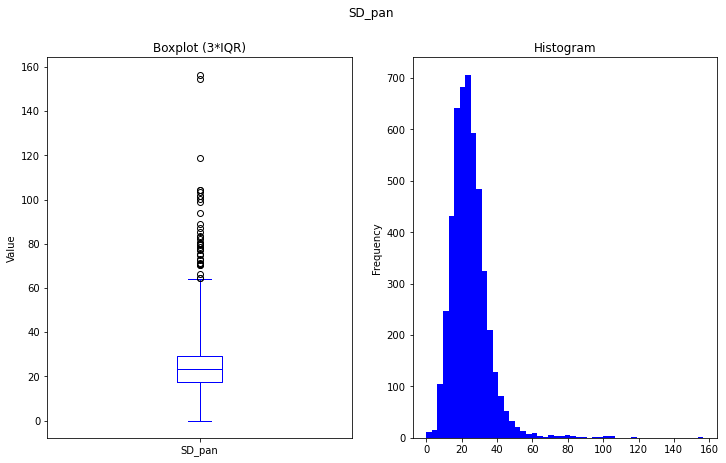

In [88]:
fig, axes = plt.subplots(1,2, figsize=(12,7))
fig.suptitle('SD_pan')
df.SD_pan.plot(kind='box',ylabel='Value', title='Boxplot (3*IQR)',color='blue',whis=3,legend=False,ax=axes[0])
df.SD_pan.plot(kind='hist',title='Histogram',color='blue',bins=50,legend=False,ax=axes[1])

In [89]:
temp2=copy.deepcopy(findingOuts('SD_pan'))
upcutS,lowcutS=temp2
df.query('SD_pan>@upcutS or SD_pan<@lowcutS').sick.groupby(df.query('SD_pan>@upcutS or SD_pan<@lowcutS').sick).count()

sick
all other land cover    39
Name: sick, dtype: int64

In [90]:
upcutS

64.26014784

In [91]:
df.query('sick=="diseased tree"').SD_pan.max()

36.8593187

Pretty far off. Now, to start the querying.

In [92]:
dfB

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,all other land cover,109.828571,183.700000,82.950000,251.750000,16.079412
1,all other land cover,130.284483,212.637931,96.896552,482.396552,21.210295
2,all other land cover,131.386555,185.466667,85.466667,419.666667,13.339998
3,all other land cover,141.345098,180.875000,81.500000,348.062500,18.213577
4,diseased tree,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...,...
4834,all other land cover,111.568773,203.588235,93.264706,403.735294,26.512777
4835,all other land cover,125.435240,206.394161,93.058394,512.270073,33.466060
4836,all other land cover,132.123859,465.343750,295.333333,499.250000,38.762967
4837,all other land cover,124.469536,215.152632,98.484211,675.915789,28.506542


In [93]:
dfB.query('Mean_Green<=@upcutG and Mean_Green>=@lowcutG',inplace=True)
dfB.query('Mean_Red<=@upcutR and Mean_Red>=@lowcutR',inplace=True)
dfB.query('SD_pan<=@upcutS and SD_pan>=@lowcutS',inplace=True)
dfB.query('GLCM_pan<=@upcutGL and GLCM_pan>=@lowcutGL',inplace=True)

In [94]:
dfB

,sick,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,all other land cover,109.828571,183.700000,82.950000,251.750000,16.079412
1,all other land cover,130.284483,212.637931,96.896552,482.396552,21.210295
2,all other land cover,131.386555,185.466667,85.466667,419.666667,13.339998
3,all other land cover,141.345098,180.875000,81.500000,348.062500,18.213577
4,diseased tree,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...,...
4828,all other land cover,141.383940,257.440000,144.640000,343.360000,39.746240
4833,all other land cover,139.734592,200.690266,90.584071,450.884956,24.663350
4834,all other land cover,111.568773,203.588235,93.264706,403.735294,26.512777
4835,all other land cover,125.435240,206.394161,93.058394,512.270073,33.466060


Note the decreased number of observations. It seems like it worked. Going to look at some charts!

<AxesSubplot:title={'center':'Histogram'}, ylabel='Frequency'>

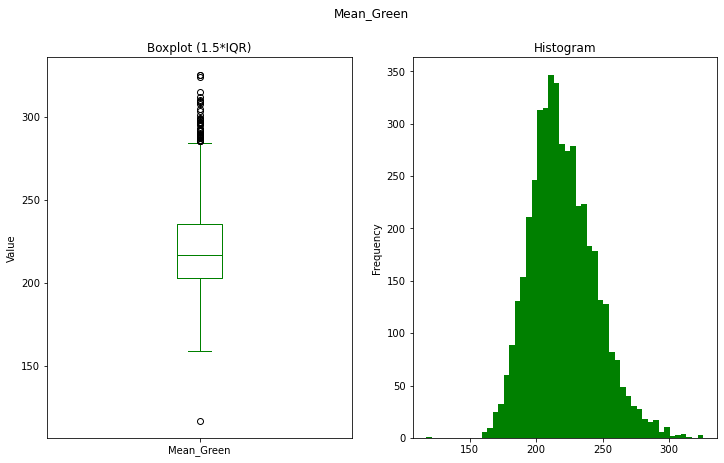

In [95]:
fig, axes = plt.subplots(1,2, figsize=(12,7))
fig.suptitle('Mean_Green')
dfB.Mean_Green.plot(kind='box',ylabel='Value', title='Boxplot (1.5*IQR)',color='green',whis=1.5,legend=False,ax=axes[0])
dfB.Mean_Green.plot(kind='hist',title='Histogram',color='green',bins=50,legend=False,ax=axes[1])

<AxesSubplot:title={'center':'Histogram'}, ylabel='Frequency'>

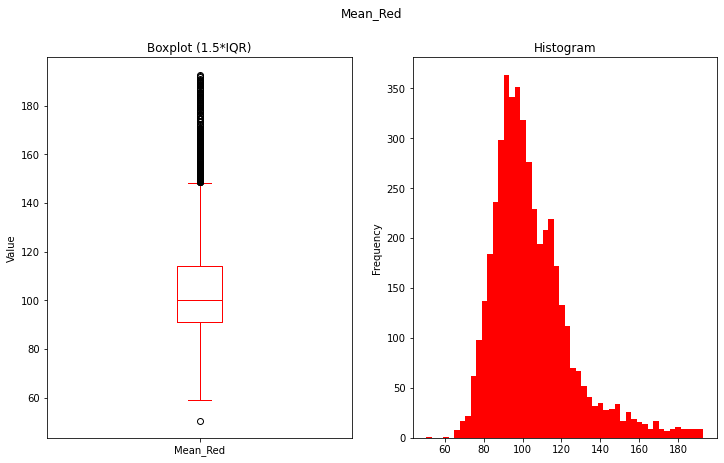

In [96]:
fig, axes = plt.subplots(1,2, figsize=(12,7))
fig.suptitle('Mean_Red')
dfB.Mean_Red.plot(kind='box',ylabel='Value', title='Boxplot (1.5*IQR)',color='red',whis=1.5,legend=False,ax=axes[0])
dfB.Mean_Red.plot(kind='hist',title='Histogram',color='red',bins=50,legend=False,ax=axes[1])

<AxesSubplot:title={'center':'Histogram'}, ylabel='Frequency'>

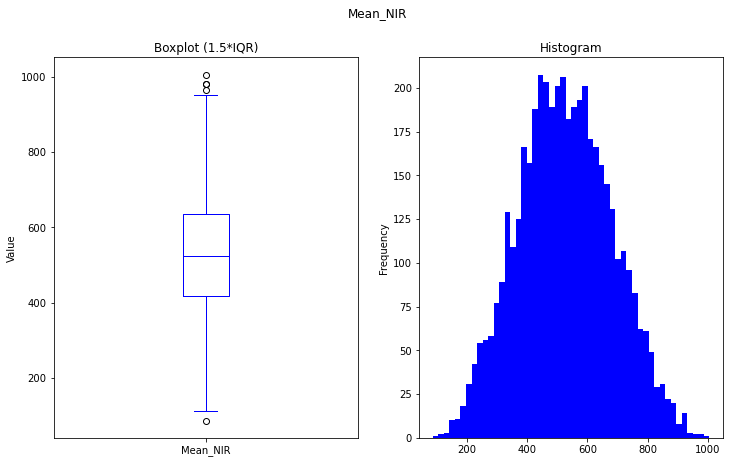

In [97]:
fig, axes = plt.subplots(1,2, figsize=(12,7))
fig.suptitle('Mean_NIR')
dfB.Mean_NIR.plot(kind='box',ylabel='Value', title='Boxplot (1.5*IQR)',color='blue',whis=1.5,legend=False,ax=axes[0])
dfB.Mean_NIR.plot(kind='hist',title='Histogram',color='blue',bins=50,legend=False,ax=axes[1])

<AxesSubplot:title={'center':'Histogram'}, ylabel='Frequency'>

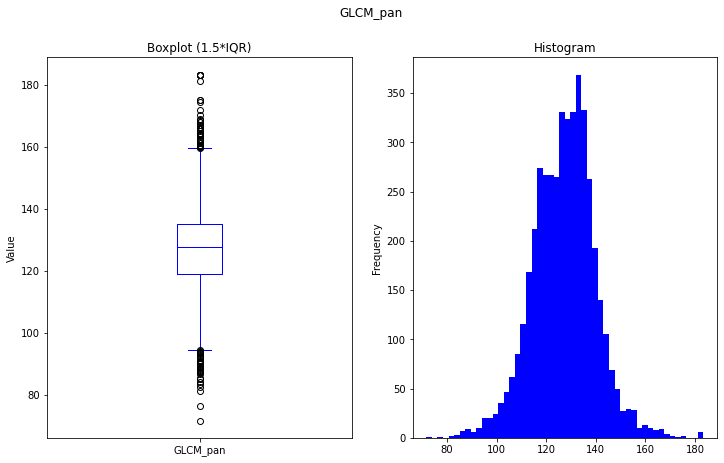

In [98]:
fig, axes = plt.subplots(1,2, figsize=(12,7))
fig.suptitle('GLCM_pan')
dfB.GLCM_pan.plot(kind='box',ylabel='Value', title='Boxplot (1.5*IQR)',color='blue',whis=1.5,legend=False,ax=axes[0])
dfB.GLCM_pan.plot(kind='hist',title='Histogram',color='blue',bins=50,legend=False,ax=axes[1])

<AxesSubplot:title={'center':'Histogram'}, ylabel='Frequency'>

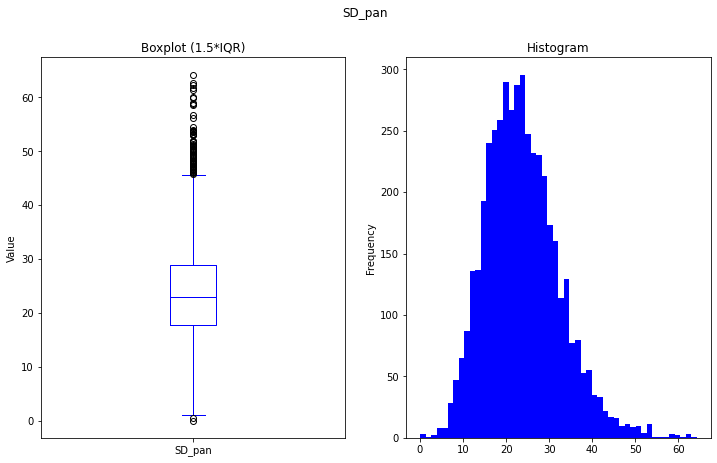

In [99]:
fig, axes = plt.subplots(1,2, figsize=(12,7))
fig.suptitle('SD_pan')
dfB.SD_pan.plot(kind='box',ylabel='Value', title='Boxplot (1.5*IQR)',color='blue',whis=1.5,legend=False,ax=axes[0])
dfB.SD_pan.plot(kind='hist',title='Histogram',color='blue',bins=50,legend=False,ax=axes[1])

## Alright. Now all major outliers (using outside of 3*IQR of the first and third quartiles) have been removed from dfB. df is original dataset. Going to rename the original dataset to dfA.

In [100]:
dfA=df

Now, for any variable/object, __A will denote that it used dfA, and __B will denote that it used dfB. For example, XA, yA is for dfA (the full dataset), and XB, yB is for dfB (the cleaned dataset), and so on.

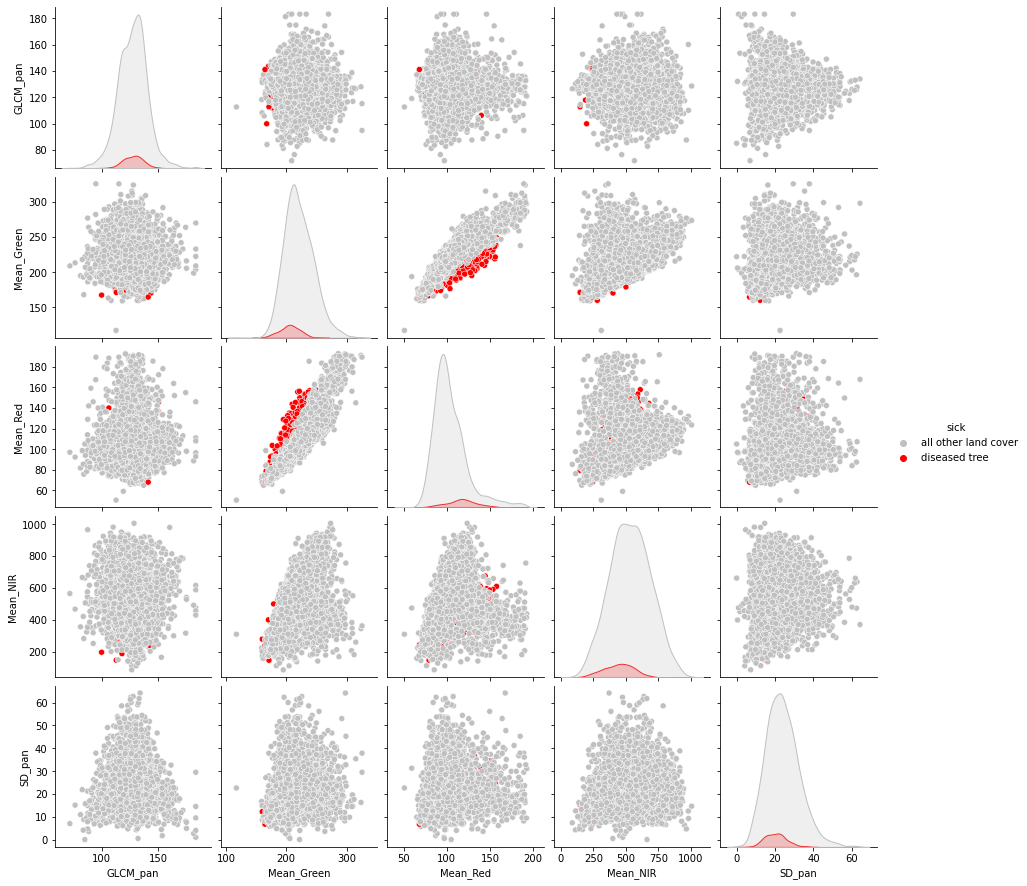

In [101]:
sns.pairplot(dfB[['GLCM_pan','Mean_Green','Mean_Red','Mean_NIR','SD_pan','sick']], hue='sick', palette={'diseased tree':'red','all other land cover':'silver'})

## Does not look like K-NN would work very well except perhaps with Mean_Red, Mean_Green.
#### Decision tree shoud work. Maybe a SVM would work.
##### SVM is too complicated for me to figure out in a reasonable amount of time, going with Random Forest instead


Going to do 3D plotting of Mean_Green, Mean_Red, Mean_NIR, with red dots being the diseased tree observations and the blue dots being all other land cover.

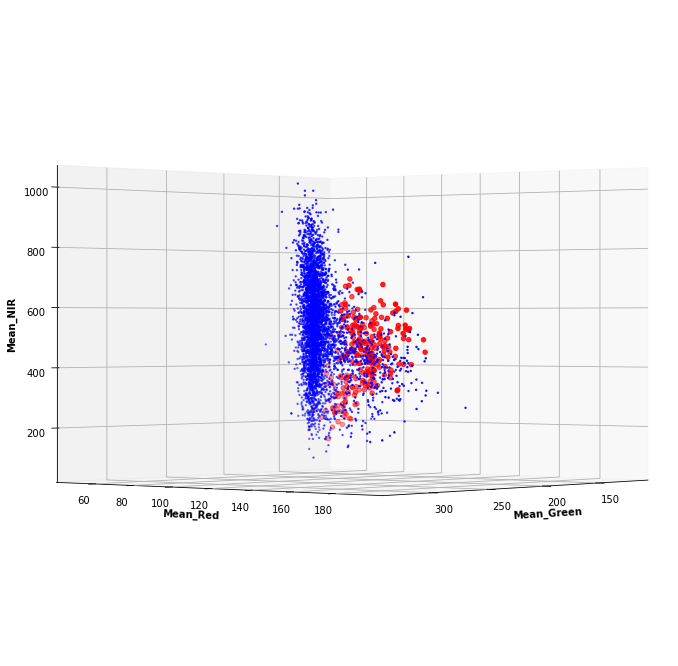

In [102]:
fig = plt.figure(figsize=(12,12))
ax= plt.axes(projection='3d')
ax.set_xlabel('Mean_Green', fontweight ='bold')
ax.set_ylabel('Mean_Red', fontweight ='bold')
ax.set_zlabel('Mean_NIR', fontweight ='bold')
xSick=dfB.query('sick=="diseased tree"').Mean_Green
ySick=dfB.query('sick=="diseased tree"').Mean_Red
zSick=dfB.query('sick=="diseased tree"').Mean_NIR
xNot=dfB.query('sick=="all other land cover"').Mean_Green
yNot=dfB.query('sick=="all other land cover"').Mean_Red
zNot=dfB.query('sick=="all other land cover"').Mean_NIR
ax.scatter3D(xNot,yNot,zNot,c='blue',s=2)
ax.scatter3D(xSick,ySick,zSick,c='red')
#ax.view_init(elevated angle in degrees, horizontal angle in degrees)
ax.view_init(0,40)

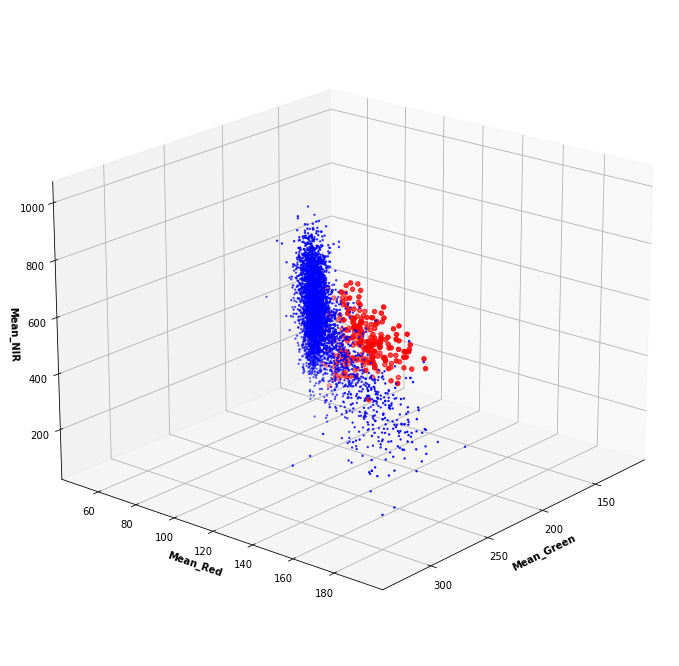

In [103]:
fig = plt.figure(figsize=(12,12))
ax= plt.axes(projection='3d')
ax.set_xlabel('Mean_Green', fontweight ='bold')
ax.set_ylabel('Mean_Red', fontweight ='bold')
ax.set_zlabel('Mean_NIR', fontweight ='bold')
xSick=dfB.query('sick=="diseased tree"').Mean_Green
ySick=dfB.query('sick=="diseased tree"').Mean_Red
zSick=dfB.query('sick=="diseased tree"').Mean_NIR
xNot=dfB.query('sick=="all other land cover"').Mean_Green
yNot=dfB.query('sick=="all other land cover"').Mean_Red
zNot=dfB.query('sick=="all other land cover"').Mean_NIR
ax.scatter3D(xNot,yNot,zNot,c='blue',s=2)
ax.scatter3D(xSick,ySick,zSick,c='red')
#ax.view_init(elevated angle in degrees, horizontal angle in degrees)
ax.view_init(20,40)

# Beginning of modelling

In [104]:
XA=dfA.iloc[:,1:]
yA=dfA.sick
XB=dfB.iloc[:,1:]
yB=dfB.sick

In [105]:
yA

0       all other land cover
1       all other land cover
2       all other land cover
3       all other land cover
4              diseased tree
                ...         
4834    all other land cover
4835    all other land cover
4836    all other land cover
4837    all other land cover
4838    all other land cover
Name: sick, Length: 4838, dtype: object

### First, gonna do both with all 5 raw features, 80/10/10 split for train, validation, test

Beginning split.

In [106]:
XA_train, XA_temp, yA_train, yA_temp = train_test_split(XA,yA, test_size=.20, random_state=17)

Going to quickly check that the train and temp (which will be split into the validation and test sets) have decent amounts of diseased tree observations.

In [107]:
XA_train.groupby(yA).count()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
sick,,,,,
all other land cover,3661,3661,3661,3661,3661
diseased tree,209,209,209,209,209


In [108]:
XA_temp.groupby(yA).count()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
sick,,,,,
all other land cover,916,916,916,916,916
diseased tree,52,52,52,52,52


Alright, good, they do. Now to split the temps into test and validation sets.

In [109]:
XA_test, XA_valid, yA_test, yA_valid = train_test_split(XA_temp,yA_temp, test_size=.50, random_state=17)

In [110]:
XA_test.groupby(yA).count()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
sick,,,,,
all other land cover,463,463,463,463,463
diseased tree,21,21,21,21,21


In [111]:
XA_valid.groupby(yA).count()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
sick,,,,,
all other land cover,453,453,453,453,453
diseased tree,31,31,31,31,31


All good there. Going to do the same thing with XB and yB to get it out of the way.

In [112]:
XB_train, XB_temp, yB_train, yB_temp = train_test_split(XB,yB, test_size=.20, random_state=17)

In [113]:
XB_train.groupby(yB).count()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
sick,,,,,
all other land cover,3442,3442,3442,3442,3442
diseased tree,204,204,204,204,204


In [114]:
XB_test, XB_valid, yB_test, yB_valid = train_test_split(XB_temp,yB_temp, test_size=.50, random_state=17)

In [115]:
XB_test.groupby(yB).count()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
sick,,,,,
all other land cover,423,423,423,423,423
diseased tree,33,33,33,33,33


In [116]:
XB_valid.groupby(yB).count()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
sick,,,,,
all other land cover,432,432,432,432,432
diseased tree,24,24,24,24,24


All good. Now to run Decision Tree with dfA

First, going to do criterion=gini, and find a good min_sample_leaf using validation set. Then going to see if things change if using entropy.

In [117]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=2)
clf = clf.fit(XA_train, yA_train)

In [118]:
yAvalid_pred = clf.predict(XA_valid)

In [119]:
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.98      0.99      0.99       453
       diseased tree       0.88      0.74      0.81        31

            accuracy                           0.98       484
           macro avg       0.93      0.87      0.90       484
        weighted avg       0.98      0.98      0.98       484



With a min_samples_leaf=2, f1-scores=[.99,.81,.98]. Going to increase until the f1 scores start getting worse.

In [120]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=5)
clf = clf.fit(XA_train, yA_train)

In [121]:
yAvalid_pred = clf.predict(XA_valid)

In [122]:
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       453
       diseased tree       0.86      0.81      0.83        31

            accuracy                           0.98       484
           macro avg       0.92      0.90      0.91       484
        weighted avg       0.98      0.98      0.98       484



With a min_samples_leaf=5, f1-scores=[.99,.80,.98]. Going to continue to increase, just in case it gets any better.

In [123]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=10)
clf = clf.fit(XA_train, yA_train)

In [124]:
yAvalid_pred = clf.predict(XA_valid)

In [125]:
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       453
       diseased tree       0.90      0.84      0.87        31

            accuracy                           0.98       484
           macro avg       0.94      0.92      0.93       484
        weighted avg       0.98      0.98      0.98       484



With a min_samples_leaf=10, f1-scores=[.99,.87,.98]. It did! Continue to increase.

In [126]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=15)
clf = clf.fit(XA_train, yA_train)

In [127]:
yAvalid_pred = clf.predict(XA_valid)

In [128]:
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.98      0.99       453
       diseased tree       0.77      0.87      0.82        31

            accuracy                           0.98       484
           macro avg       0.88      0.93      0.90       484
        weighted avg       0.98      0.98      0.98       484



With a min_samples_leaf=15, f1-scores=[.99,.82,.98]. Going to decrease to try to find optimal.

In [129]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=13)
clf = clf.fit(XA_train, yA_train)

In [130]:
yAvalid_pred = clf.predict(XA_valid)

In [131]:
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       453
       diseased tree       0.89      0.81      0.85        31

            accuracy                           0.98       484
           macro avg       0.94      0.90      0.92       484
        weighted avg       0.98      0.98      0.98       484



With a min_samples_leaf=13, f1-scores=[.99,.85,.98]. Got slightly better. Going to decrease again.

In [132]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=11)
clf = clf.fit(XA_train, yA_train)

In [133]:
yAvalid_pred = clf.predict(XA_valid)

In [134]:
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       453
       diseased tree       0.90      0.84      0.87        31

            accuracy                           0.98       484
           macro avg       0.94      0.92      0.93       484
        weighted avg       0.98      0.98      0.98       484



With a min_samples_leaf=11, f1-scores=[.99,.87,.98]. Now back to the level it was at min_samples_leaf=10. Going to quickly check 12:

In [135]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=12)
clf = clf.fit(XA_train, yA_train)

In [136]:
yAvalid_pred = clf.predict(XA_valid)

In [137]:
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       453
       diseased tree       0.90      0.84      0.87        31

            accuracy                           0.98       484
           macro avg       0.94      0.92      0.93       484
        weighted avg       0.98      0.98      0.98       484



Also ended up at same level. So, it seems like the best result I can get for criterion=gini is f1-scores .99, .87, .98, at min_samples_leaf=11 (or 10 or 12).

Now going to check criterion=entropy.

In [138]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=2)
clf = clf.fit(XA_train, yA_train)
yAvalid_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.98      1.00      0.99       453
       diseased tree       0.96      0.74      0.84        31

            accuracy                           0.98       484
           macro avg       0.97      0.87      0.91       484
        weighted avg       0.98      0.98      0.98       484



Already very good. Going to mess around with min_samples_leaf, the same way as before:

In [139]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=5)
clf = clf.fit(XA_train, yA_train)
yAvalid_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       453
       diseased tree       0.89      0.81      0.85        31

            accuracy                           0.98       484
           macro avg       0.94      0.90      0.92       484
        weighted avg       0.98      0.98      0.98       484



In [140]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=10)
clf = clf.fit(XA_train, yA_train)
yAvalid_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      1.00      0.99       453
       diseased tree       0.93      0.87      0.90        31

            accuracy                           0.99       484
           macro avg       0.96      0.93      0.95       484
        weighted avg       0.99      0.99      0.99       484



That is now the best report (judging by f1 scores) we've gotten so far, as our overall is .99. Continue messing around, see if we can improve diseased tree's scores any more:

In [141]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=15)
clf = clf.fit(XA_train, yA_train)
yAvalid_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.98      0.99       453
       diseased tree       0.78      0.81      0.79        31

            accuracy                           0.97       484
           macro avg       0.88      0.90      0.89       484
        weighted avg       0.97      0.97      0.97       484



In [142]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=11)
clf = clf.fit(XA_train, yA_train)
yAvalid_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       453
       diseased tree       0.87      0.87      0.87        31

            accuracy                           0.98       484
           macro avg       0.93      0.93      0.93       484
        weighted avg       0.98      0.98      0.98       484



####  >10 does not seem to help. Checking <10 and >5:

In [143]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=10) #for reference
clf = clf.fit(XA_train, yA_train)
yAvalid_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      1.00      0.99       453
       diseased tree       0.93      0.87      0.90        31

            accuracy                           0.99       484
           macro avg       0.96      0.93      0.95       484
        weighted avg       0.99      0.99      0.99       484



In [144]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=9)
clf = clf.fit(XA_train, yA_train)
yAvalid_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      1.00      0.99       453
       diseased tree       0.93      0.87      0.90        31

            accuracy                           0.99       484
           macro avg       0.96      0.93      0.95       484
        weighted avg       0.99      0.99      0.99       484



In [145]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=8)
clf = clf.fit(XA_train, yA_train)
yAvalid_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       453
       diseased tree       0.87      0.87      0.87        31

            accuracy                           0.98       484
           macro avg       0.93      0.93      0.93       484
        weighted avg       0.98      0.98      0.98       484



### Alright! The best we have gotten for decision tree for the XA_train,yA_train,XA_valid,yA_valid sets is criterion=entropy, min_samples_leaf=10. Now going to get the final results using XA_test and yA_test via those parameters.

In [146]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=10)
clf = clf.fit(XA_train, yA_train)
yA_pred = clf.predict(XA_test)

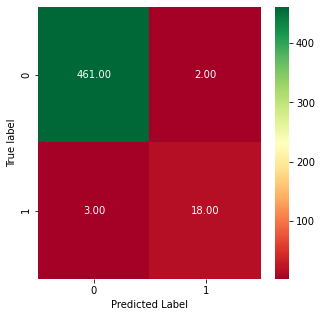

In [147]:
plot_cm(yA_test, yA_pred)

That looks a little funky, due to the low amounts of diseased tree values. Going to adjust the maximum value anchor for the color map to make it more visually accurrate to how well it did. Chose vmax=21, as that was the amount of diseased tree observations in yA_test, XA_test, and thus the best it could have done, and it did so well predicting all other land cover that the fact that it is pure green doesn't matter much, as it was nearly entirely correct.

Text(0.5, 51.0, 'Predicted Label')

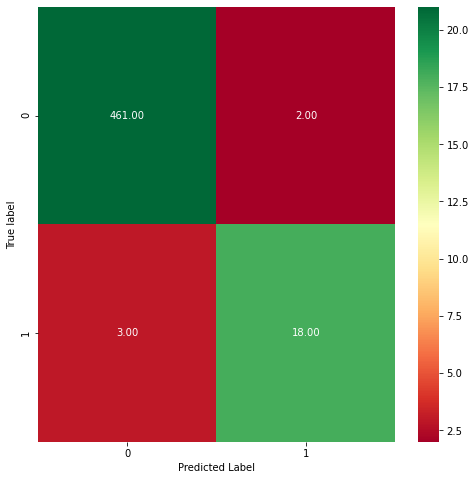

In [152]:
cm = confusion_matrix(yA_test, yA_pred)
fig = plt.figure(figsize=(8,8))
heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn',vmax=21)
plt.ylabel('True label')
plt.xlabel('Predicted Label')

In [153]:
print(classification_report(yA_test,yA_pred)) 

                      precision    recall  f1-score   support

all other land cover       0.99      1.00      0.99       463
       diseased tree       0.90      0.86      0.88        21

            accuracy                           0.99       484
           macro avg       0.95      0.93      0.94       484
        weighted avg       0.99      0.99      0.99       484



In [154]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=XA.columns,
                                class_names=('all other land cover', 'diseased trees'),
                                filled=True, 
                                rounded=True,
                                label='all',
                                special_characters=True,
                                proportion=False,
                                rotate=True)
graph = graphviz.Source(dot_data)
graph.render("sick trees test 1")

'sick trees test 1.pdf'

### First test went extremely well!

## Now, to do the same with the dfB sets.

In [156]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=2)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       432
       diseased tree       0.81      0.88      0.84        24

            accuracy                           0.98       456
           macro avg       0.90      0.93      0.92       456
        weighted avg       0.98      0.98      0.98       456



In [157]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=5)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.98      0.99       432
       diseased tree       0.76      0.92      0.83        24

            accuracy                           0.98       456
           macro avg       0.88      0.95      0.91       456
        weighted avg       0.98      0.98      0.98       456



In [158]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=10)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.98      0.99       432
       diseased tree       0.77      0.96      0.85        24

            accuracy                           0.98       456
           macro avg       0.88      0.97      0.92       456
        weighted avg       0.99      0.98      0.98       456



In [159]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=15)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.98      0.99       432
       diseased tree       0.70      0.96      0.81        24

            accuracy                           0.98       456
           macro avg       0.85      0.97      0.90       456
        weighted avg       0.98      0.98      0.98       456



In [160]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=12)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.98      0.99       432
       diseased tree       0.77      0.96      0.85        24

            accuracy                           0.98       456
           macro avg       0.88      0.97      0.92       456
        weighted avg       0.99      0.98      0.98       456



In [161]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=7)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       432
       diseased tree       0.78      0.88      0.82        24

            accuracy                           0.98       456
           macro avg       0.89      0.93      0.91       456
        weighted avg       0.98      0.98      0.98       456



In [162]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=8)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       432
       diseased tree       0.81      0.88      0.84        24

            accuracy                           0.98       456
           macro avg       0.90      0.93      0.92       456
        weighted avg       0.98      0.98      0.98       456



### Best for criterion=gini was min_samples_leaf=10. For reference:

In [163]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=10) #For reference
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.98      0.99       432
       diseased tree       0.77      0.96      0.85        24

            accuracy                           0.98       456
           macro avg       0.88      0.97      0.92       456
        weighted avg       0.99      0.98      0.98       456



In [164]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=2)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.98      0.99       432
       diseased tree       0.77      0.96      0.85        24

            accuracy                           0.98       456
           macro avg       0.88      0.97      0.92       456
        weighted avg       0.99      0.98      0.98       456



In [165]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=5)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.98      0.99       432
       diseased tree       0.71      0.92      0.80        24

            accuracy                           0.98       456
           macro avg       0.85      0.95      0.89       456
        weighted avg       0.98      0.98      0.98       456



In [166]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=10)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.99      0.99       432
       diseased tree       0.79      0.92      0.85        24

            accuracy                           0.98       456
           macro avg       0.89      0.95      0.92       456
        weighted avg       0.98      0.98      0.98       456



In [167]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=15)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.97      0.98       432
       diseased tree       0.65      0.92      0.76        24

            accuracy                           0.97       456
           macro avg       0.82      0.94      0.87       456
        weighted avg       0.98      0.97      0.97       456



In [168]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=12)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.98      0.99       432
       diseased tree       0.71      0.92      0.80        24

            accuracy                           0.98       456
           macro avg       0.85      0.95      0.89       456
        weighted avg       0.98      0.98      0.98       456



In [169]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=4)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.98      0.99       432
       diseased tree       0.72      0.96      0.82        24

            accuracy                           0.98       456
           macro avg       0.86      0.97      0.90       456
        weighted avg       0.98      0.98      0.98       456



In [170]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=2)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.98      0.99       432
       diseased tree       0.72      0.96      0.82        24

            accuracy                           0.98       456
           macro avg       0.86      0.97      0.90       456
        weighted avg       0.98      0.98      0.98       456



### The best was actually min_samples_leaf=2 for criterion = 'entropy'. Now to compare the best of both:

In [171]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=2)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.98      0.99       432
       diseased tree       0.77      0.96      0.85        24

            accuracy                           0.98       456
           macro avg       0.88      0.97      0.92       456
        weighted avg       0.99      0.98      0.98       456



In [172]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=10) #For reference
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       1.00      0.98      0.99       432
       diseased tree       0.77      0.96      0.85        24

            accuracy                           0.98       456
           macro avg       0.88      0.97      0.92       456
        weighted avg       0.99      0.98      0.98       456



#### Alright, the best for this set was criterion='entropy', min_samples_leaf=2. Now to get the final score:

In [173]:
clf = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=2)
clf = clf.fit(XB_train, yB_train)
yB_pred = clf.predict(XB_test)

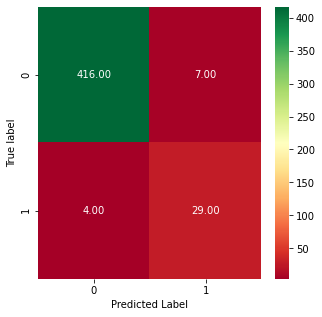

In [174]:
plot_cm(yB_test, yB_pred)

In [175]:
yB_test.groupby(yB_test).count()

sick
all other land cover    423
diseased tree            33
Name: sick, dtype: int64

Text(0.5, 51.0, 'Predicted Label')

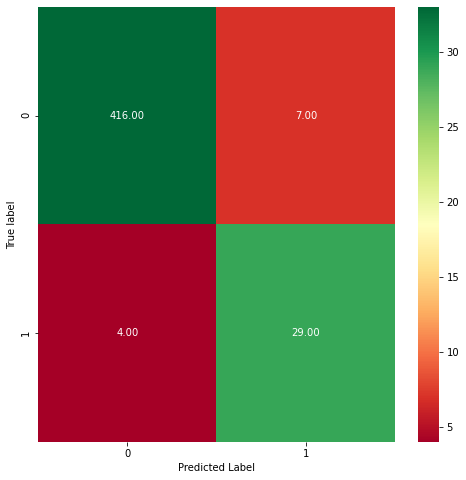

In [177]:
cm = confusion_matrix(yB_test, yB_pred)
fig = plt.figure(figsize=(8,8))
heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn',vmax=33)
plt.ylabel('True label')
plt.xlabel('Predicted Label')

In [178]:
print(classification_report(yB_test,yB_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.98      0.99       423
       diseased tree       0.81      0.88      0.84        33

            accuracy                           0.98       456
           macro avg       0.90      0.93      0.91       456
        weighted avg       0.98      0.98      0.98       456



## Huh. The set with outliers removed actually did a little worse.

#### Now going to do another test with decision trees, but this time normalize the data. Going to use dfB.

In [179]:
XB

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,109.828571,183.700000,82.950000,251.750000,16.079412
1,130.284483,212.637931,96.896552,482.396552,21.210295
2,131.386555,185.466667,85.466667,419.666667,13.339998
3,141.345098,180.875000,81.500000,348.062500,18.213577
4,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...
4828,141.383940,257.440000,144.640000,343.360000,39.746240
4833,139.734592,200.690266,90.584071,450.884956,24.663350
4834,111.568773,203.588235,93.264706,403.735294,26.512777
4835,125.435240,206.394161,93.058394,512.270073,33.466060


## Below is normalization formula:

In [180]:
XBn=(XB-XB.min())/(XB.max()-XB.min())

In [181]:
XBn

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,0.341601,0.318961,0.227636,0.179812,0.250334
1,0.524959,0.457782,0.325709,0.430783,0.330215
2,0.534837,0.327436,0.245333,0.362525,0.207685
3,0.624102,0.305409,0.217439,0.284611,0.283560
4,0.445173,0.485218,0.432044,0.370077,0.297099
...,...,...,...,...,...
4828,0.624450,0.672705,0.661445,0.279495,0.618794
4833,0.609666,0.400467,0.281319,0.396495,0.383974
4834,0.357199,0.414369,0.300170,0.345190,0.412767
4835,0.481492,0.427829,0.298719,0.463289,0.521020


<AxesSubplot:>

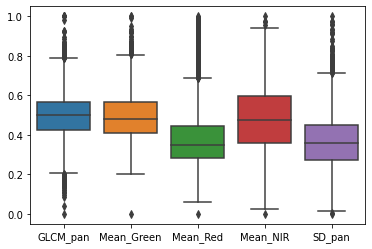

In [182]:
sns.boxplot(data=XBn)

### Data has been normalized. Now time to split again. Going to do a 70/15/15 split.

In [183]:
XB_train, XB_temp, yB_train, yB_temp = train_test_split(XBn,yB, test_size=.30, random_state=77)

In [184]:
XB_train.groupby(yB).count()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
sick,,,,,
all other land cover,3016,3016,3016,3016,3016
diseased tree,174,174,174,174,174


In [185]:
XB_test, XB_valid, yB_test, yB_valid = train_test_split(XB_temp,yB_temp, test_size=.50, random_state=420)

In [186]:
XB_test.groupby(yB).count()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
sick,,,,,
all other land cover,642,642,642,642,642
diseased tree,42,42,42,42,42


In [187]:
XB_valid.groupby(yB).count()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
sick,,,,,
all other land cover,639,639,639,639,639
diseased tree,45,45,45,45,45


In [188]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=2)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.98      0.99      0.99       639
       diseased tree       0.87      0.76      0.81        45

            accuracy                           0.98       684
           macro avg       0.93      0.87      0.90       684
        weighted avg       0.98      0.98      0.98       684



In [189]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=10)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.98      0.99      0.99       639
       diseased tree       0.83      0.78      0.80        45

            accuracy                           0.98       684
           macro avg       0.91      0.88      0.90       684
        weighted avg       0.97      0.98      0.97       684



In [190]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=5)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.98      0.99      0.99       639
       diseased tree       0.85      0.76      0.80        45

            accuracy                           0.98       684
           macro avg       0.92      0.87      0.89       684
        weighted avg       0.97      0.98      0.97       684



In [191]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=3)
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       639
       diseased tree       0.86      0.82      0.84        45

            accuracy                           0.98       684
           macro avg       0.92      0.91      0.91       684
        weighted avg       0.98      0.98      0.98       684



Best with criterion=gini is .98 overall, .84 diseased tree, .99 all other, using min_samples_leaf=3. Now to check entropy.

In [192]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=2,criterion='entropy')
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.98      0.99      0.99       639
       diseased tree       0.83      0.78      0.80        45

            accuracy                           0.98       684
           macro avg       0.91      0.88      0.90       684
        weighted avg       0.97      0.98      0.97       684



In [193]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=5,criterion='entropy')
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       639
       diseased tree       0.82      0.80      0.81        45

            accuracy                           0.98       684
           macro avg       0.90      0.89      0.90       684
        weighted avg       0.97      0.98      0.98       684



In [194]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=10,criterion='entropy')
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.98      0.99      0.99       639
       diseased tree       0.83      0.78      0.80        45

            accuracy                           0.98       684
           macro avg       0.91      0.88      0.90       684
        weighted avg       0.97      0.98      0.97       684



In [195]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=3,criterion='entropy')
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.99      0.99       639
       diseased tree       0.82      0.82      0.82        45

            accuracy                           0.98       684
           macro avg       0.90      0.90      0.90       684
        weighted avg       0.98      0.98      0.98       684



In [196]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=7,criterion='entropy')
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.98      0.99      0.99       639
       diseased tree       0.81      0.76      0.78        45

            accuracy                           0.97       684
           macro avg       0.90      0.87      0.88       684
        weighted avg       0.97      0.97      0.97       684



In [197]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=20,criterion='entropy')
clf = clf.fit(XB_train, yB_train)
yBvalid_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBvalid_pred))

                      precision    recall  f1-score   support

all other land cover       0.98      0.99      0.98       639
       diseased tree       0.78      0.64      0.71        45

            accuracy                           0.96       684
           macro avg       0.88      0.82      0.84       684
        weighted avg       0.96      0.96      0.96       684



So, best one we got was criterion=gini, min_samples_leaf=3. Now time to test it.

In [198]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=3)
clf = clf.fit(XB_train, yB_train)
yB_pred = clf.predict(XB_test)

In [199]:
print(classification_report(yB_test,yB_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      0.98      0.98       642
       diseased tree       0.72      0.79      0.75        42

            accuracy                           0.97       684
           macro avg       0.85      0.88      0.87       684
        weighted avg       0.97      0.97      0.97       684



Text(0.5, 24.0, 'Predicted Label')

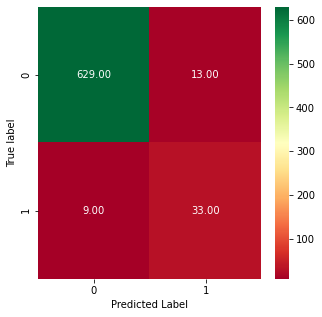

In [200]:
cm = confusion_matrix(yB_test, yB_pred)
fig = plt.figure(figsize=(5,5))
heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
plt.ylabel('True label')
plt.xlabel('Predicted Label')

Text(0.5, 51.0, 'Predicted Label')

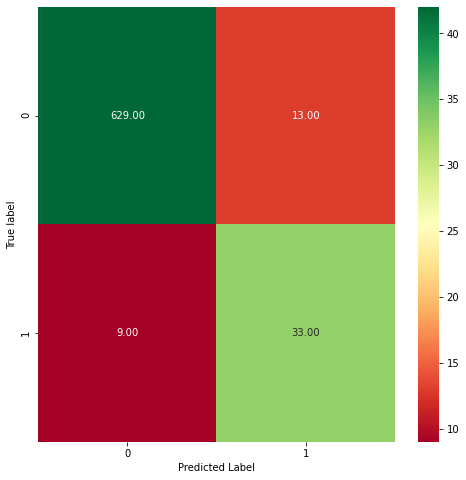

In [203]:
cm = confusion_matrix(yB_test, yB_pred)
fig = plt.figure(figsize=(8,8))
heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn',vmax=42)
plt.ylabel('True label')
plt.xlabel('Predicted Label')

In [202]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=XBn.columns,
                                class_names=('all other land cover', 'diseased trees'),
                                filled=True, 
                                rounded=True,
                                label='all',
                                special_characters=True,
                                proportion=False,
                                rotate=True)
graph = graphviz.Source(dot_data)
graph.render("sick trees test 3 normalized no outliers")

'sick trees test 3 normalized no outliers.pdf'

Next test we're going to do is Random Forest

# Start of Random Forest.

## Note: This section has several computationally intensive functions/cells. Run any cell that has a function that looks like 'ranForTest#' at your own risk.

In [204]:
yA=dfA.sick
XA=dfA.iloc[:,1:]
XA_train, XA_temp, yA_train, yA_temp = train_test_split(XA,yA, test_size=.30, random_state=69)
XA_test, XA_valid, yA_test, yA_valid = train_test_split(XA_temp,yA_temp, test_size=.50, random_state=420)

In [205]:
yA_train.groupby(yA_train).count()

sick
all other land cover    3206
diseased tree            180
Name: sick, dtype: int64

In [206]:
yA_valid.groupby(yA_valid).count()

sick
all other land cover    689
diseased tree            37
Name: sick, dtype: int64

In [207]:
yA_test.groupby(yA_test).count()

sick
all other land cover    682
diseased tree            44
Name: sick, dtype: int64

In [208]:
yA_train.shape
yA_test.shape
yA_valid.shape

(726,)

Now to begin messing with different aspects of the model. Going to use n_estimators=100, criterion='gini' as the baseline (as those are the default values for those parameters)-- anything better than that will replace it as the baseline until we give up. Funnily enough, it ended up amazing. 

In [209]:
clf = RandomForestClassifier(n_estimators=100,criterion='gini')
clf.fit(XA_train,np.ravel(yA_train))
yAv_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAv_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      1.00      0.99       689
       diseased tree       0.94      0.81      0.87        37

            accuracy                           0.99       726
           macro avg       0.96      0.90      0.93       726
        weighted avg       0.99      0.99      0.99       726



Text(0.5, 24.0, 'Predicted Label')

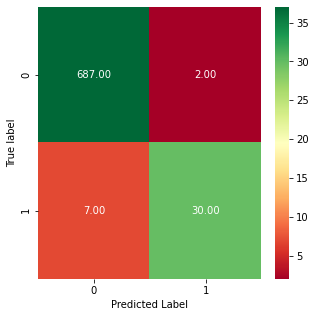

In [210]:
cm = confusion_matrix(yA_valid, yAv_pred)
fig = plt.figure(figsize=(5,5))
heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn',vmax=37)
plt.ylabel('True label')
plt.xlabel('Predicted Label')

Across 5 run throughs, all have had an overall score of .99, at least .85 as its f1-score for diseased tree (with .84 being the lowest, .91 being the highest thus far), and all other land cover has always had a precision of .99 and a recall of 1.00 (and f1-score of at least .99). The best run seen thus far for diseased tree was: 1.00 precision, .84 recall, .91 f1-score. It's biggest struggle seems to be with diseased tree recall.

#### Going to make a function to calculate the distribution of f1-scores for diseased tree across a wide variety of runs. Then, I can compare that data, instead of manually running the cell over and over again and eyeballinng the most frequent values. Will change the function slightly when I want to test different parameters, and increment the number at the end of the function name to keep each for comparison. This function utilizes the fact that the classification_report function returns a dictionary when the output_dict parameter is set to True. Here is an excerpt from the classification_report docstring (accessed by running classification_report?):
#### report : string / dict
####    Text summary of the precision, recall, F1 score for each class.
####    Dictionary returned if output_dict is True. Dictionary has the
####    following structure::
####
####        {'label 1': {'precision':0.5,
####                     'recall':1.0,
####                     'f1-score':0.67,
####                     'support':1},
####         'label 2': { ... },
####          ...
####        }
#### See example below, and then the function being created based off of that. The main area of interest is the f1-score of diseased tree, but I'd also like to see how many times (if any) the overall accuracy dips below .99 (when rounded, so when accuracy <=.985

In [211]:
clf = RandomForestClassifier(n_estimators=100,criterion='gini')
clf.fit(XA_train,np.ravel(yA_train))
yAv_pred = clf.predict(XA_valid)
classification_report(yA_valid,yAv_pred,output_dict=True)

{'all other land cover': {'precision': 0.9899280575539569,
  'recall': 0.9985486211901307,
  'f1-score': 0.9942196531791908,
  'support': 689},
 'diseased tree': {'precision': 0.967741935483871,
  'recall': 0.8108108108108109,
  'f1-score': 0.8823529411764706,
  'support': 37},
 'accuracy': 0.9889807162534435,
 'macro avg': {'precision': 0.9788349965189139,
  'recall': 0.9046797160004707,
  'f1-score': 0.9382862971778307,
  'support': 726},
 'weighted avg': {'precision': 0.9887973598726989,
  'recall': 0.9889807162534435,
  'f1-score': 0.9885184571129365,
  'support': 726}}

In [214]:
def ranForTest1(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='gini')
        clf.fit(XA_train,np.ravel(yA_train))
        yAv_pred = clf.predict(XA_valid)
        report= classification_report(yA_valid,yAv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Gini')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Testing it out:

Overall accuracy dipped below .99 5 times, median was 0.9876
Median values for diseased tree:
f1-score: 0.870      precision: 0.938    recall: 0.811


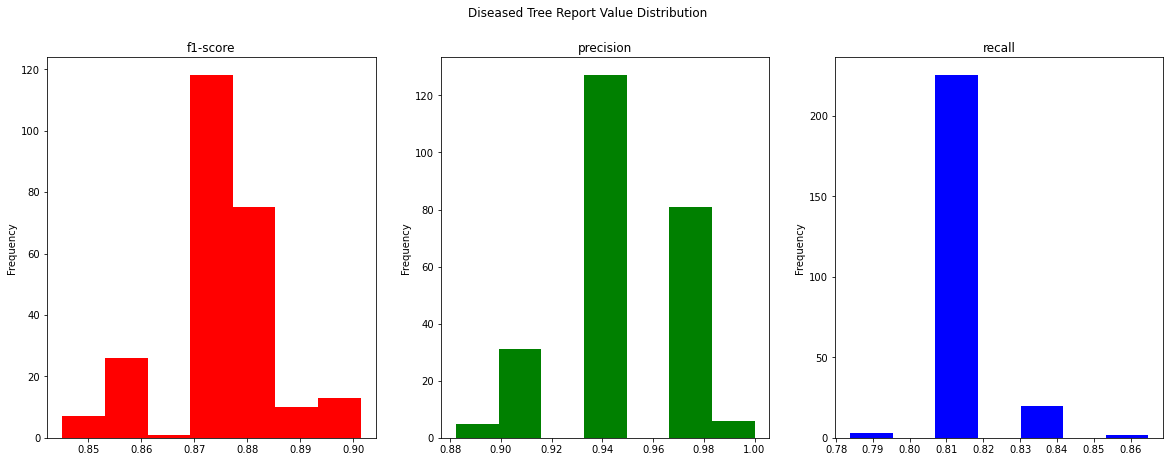

In [682]:
ranForTest1(250)

As of this markdown comment being written, the last run had overall accuracy dip below .99 5 times, and the median for overall accuracy was .9876. The median values for diseased tree in the reort were: f1-score: .870,  precision: .938,  recall: .811. (Still for diseased tree, of course) Via eyeballing the histograms, the mode for f1-score was between .87 and .88, the mode for precision was right around .94 (leaning higher), and the mode for recall was right around .81 (leaning higher.)

In [215]:
#clf = RandomForestClassifier(n_estimators=1000,criterion='gini')
#clf.fit(XA_train,np.ravel(yA_train))
#yAv_pred = clf.predict(XA_valid)
#print(classification_report(yA_valid,yAv_pred))

Ran the above code a few times, bringing the number of estimators very far up (and the run time). However, there was no noticeable difference in quality over the base line, so I'm going to continue with n_estimaors=100 for now.

Going to test out criterion='entropy', first just by looking at a random classification report, then via a modified version of the function. If 

In [216]:
clf = RandomForestClassifier(n_estimators=100,criterion='entropy')
clf.fit(XA_train,np.ravel(yA_train))
yAv_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAv_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      1.00      0.99       689
       diseased tree       0.94      0.84      0.89        37

            accuracy                           0.99       726
           macro avg       0.97      0.92      0.94       726
        weighted avg       0.99      0.99      0.99       726



In [217]:
def ranForTest2(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='entropy')
        clf.fit(XA_train,np.ravel(yA_train))
        yAv_pred = clf.predict(XA_valid)
        report= classification_report(yA_valid,yAv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Entropy
Overall accuracy dipped below .99 5 times, median was 0.9876
Median values for diseased tree:
f1-score: 0.873      precision: 0.938    recall: 0.838


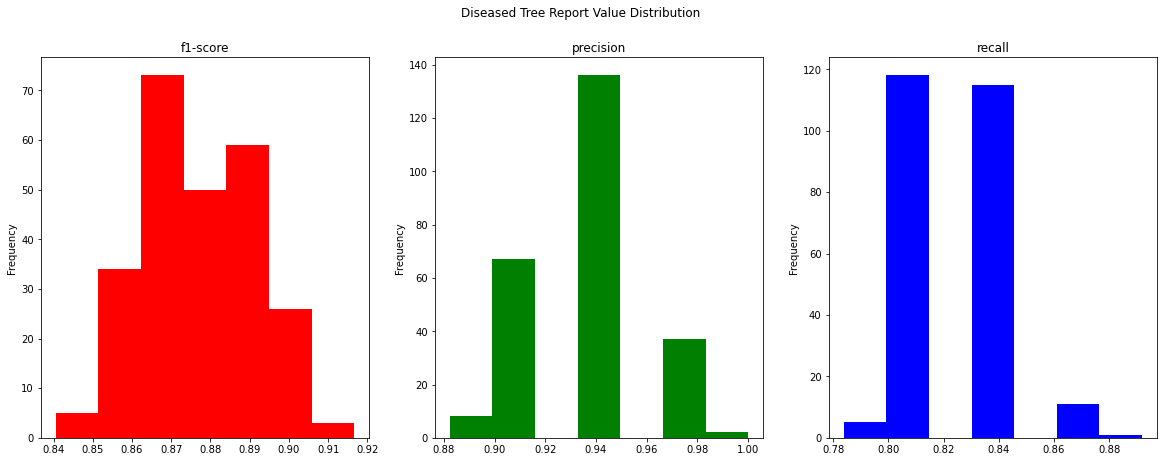

In [700]:
ranForTest2(250)

As of this markdown comment being written, the overall accuracy dipped below .99 3 times, and the median was .9890, a bit higher than with criterion='gini'. As well, each of the median values for diseased tree was at least as high as the baseline: f1-score: .882 (vs .870), precision: .938 (vs .938), recall: .838  (vs .811). Going to use criterion='entropy' as new baseline, and continue using that. Now, to check out what happens with class_weight=balanced.

In [218]:
clf = RandomForestClassifier(n_estimators=100,criterion='entropy',class_weight='balanced')
clf.fit(XA_train,np.ravel(yA_train))
yAv_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAv_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      1.00      0.99       689
       diseased tree       0.97      0.84      0.90        37

            accuracy                           0.99       726
           macro avg       0.98      0.92      0.95       726
        weighted avg       0.99      0.99      0.99       726



In [219]:
def ranForTest3(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='entropy',class_weight='balanced')
        clf.fit(XA_train,np.ravel(yA_train))
        yAv_pred = clf.predict(XA_valid)
        report= classification_report(yA_valid,yAv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy, class_weight=balanced')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Overall accuracy dipped below .99 30 times, median was 0.9876
Median values for diseased tree:
f1-score: 0.873      precision: 0.939    recall: 0.811


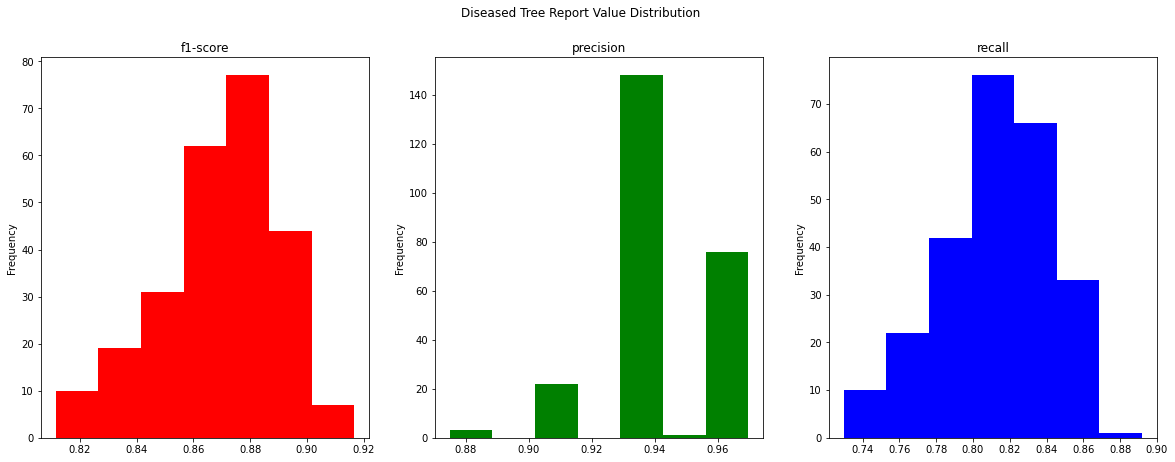

In [688]:
ranForTest3(250)

As of this markdown comment being written, the overall accuracy dipped below .99 30 times (much higher than seen before), however, and the median was .9876, not much lower than without class_weight='balanced'. This would be okay if the scores for diseased tree improved-- however, the median f1-score dropped from .882 to .873, the median precision improved slightly going from .938 to .939, and recall dropped from .838 to .811. So, did not improve in any meaningful way, and took super long to run. Test 2 is still baseline (criterion=entropy.) Now going to try class_weight='balanced_subsample'.

In [220]:
clf = RandomForestClassifier(n_estimators=100,criterion='entropy',class_weight='balanced_subsample')
clf.fit(XA_train,np.ravel(yA_train))
yAv_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAv_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      1.00      0.99       689
       diseased tree       0.97      0.78      0.87        37

            accuracy                           0.99       726
           macro avg       0.98      0.89      0.93       726
        weighted avg       0.99      0.99      0.99       726



In [221]:
def ranForTest4(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='entropy',class_weight='balanced_subsample')
        clf.fit(XA_train,np.ravel(yA_train))
        yAv_pred = clf.predict(XA_valid)
        report= classification_report(yA_valid,yAv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy, class_weight=balanced_subsample')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Entropy, class_weight=balanced_subsample
Overall accuracy dipped below .99 27 times, median was 0.9876
Median values for diseased tree:
f1-score: 0.873      precision: 0.939    recall: 0.811


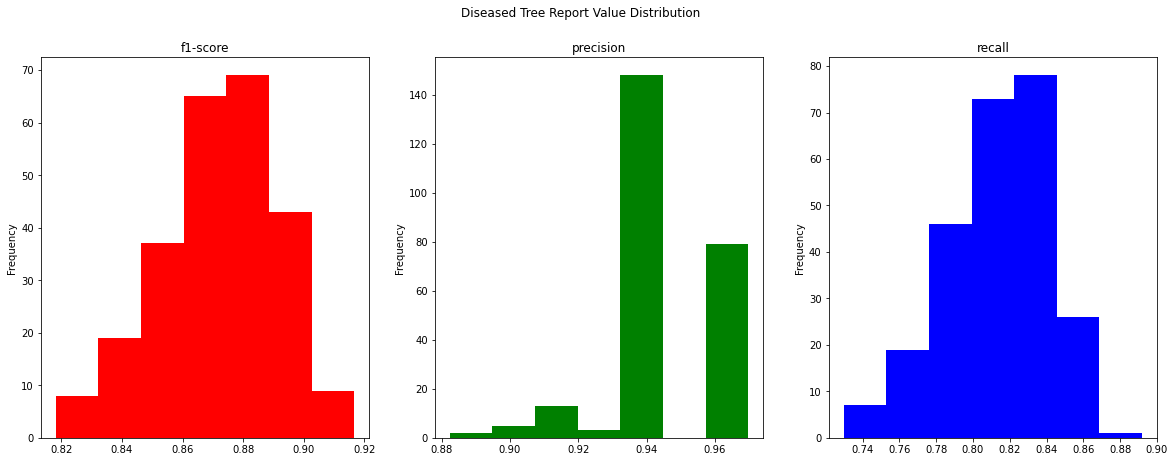

In [696]:
ranForTest4(250)

As of this markdown comment being written, the overall accuracy dipped below .99 27 times, however, and the median was .9876, not much lower than without class_weight='balanced_subsample'. This would be okay if the scores for diseased tree improved-- however, the median f1-score dropped from .882 to .873, the median precision improved slightly going from .938 to .939, and recall dropped from .838 to .811 (notably, the exact same as when class_weight=balanced. So, did not improve in any meaningful way, and took super long to run.

## We've found criterion=entropy is best so far. Now, time to make it start running faster by 'pruning', as it were. So, going to begin setting parameters that restrict, and weigh decreased run time (if any) against decreased effectiveness (if any).
## Note: As of this being written, ranForTest2(250), our baseline, took 1 minute and 40 seconds to run.

First, min_samples_split. The default value is 2, so I'm going to raise it to 5, see how much that helps runtime.

In [222]:
clf = RandomForestClassifier(n_estimators=100,criterion='entropy',min_samples_split=10)
clf.fit(XA_train,np.ravel(yA_train))
yAv_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAv_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      1.00      0.99       689
       diseased tree       0.97      0.84      0.90        37

            accuracy                           0.99       726
           macro avg       0.98      0.92      0.95       726
        weighted avg       0.99      0.99      0.99       726



In [223]:
def ranForTest5(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='entropy',min_samples_split=10)
        clf.fit(XA_train,np.ravel(yA_train))
        yAv_pred = clf.predict(XA_valid)
        report= classification_report(yA_valid,yAv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy, min_samples_split=10')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Entropy, min_samples_split=10
Overall accuracy dipped below .99 0 times, median was 0.9890
Median values for diseased tree:
f1-score: 0.886      precision: 0.939    recall: 0.838


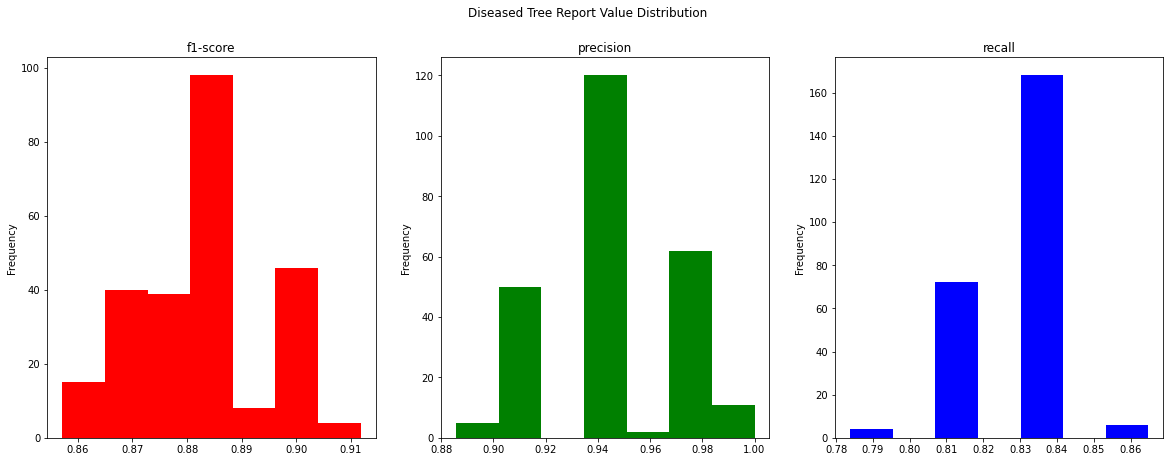

In [703]:
ranForTest5(250)

##### This took 1 minute, 38 seconds to run, barely any improvement over the baseline of 1 miute, 40 seconds.
##### Baseline medians: f1-score: 0.873      precision: 0.938    recall: 0.838
#### As of this markdown comment being written, the overall accuracy dipped below .99 0 (vs 3) times, and the median was .9890, the same as the baseline. As well, each of the median values for diseased tree was at least as high as the baseline: f1-score: .886 (vs .882), precision: .939 (vs .938), recall: .838 (vs .838). Going to use this as new baseline.

###  Baseline:
#### ranForTest5: entropy, min_samples_split=10, n_estimators=100
##### Overall accuracy dipped below .99 0 times, median was 0.9890
##### Median values for diseased tree:
##### f1-score: 0.886      precision: 0.939    recall: 0.838
#### Runtime: 1 minute, 38 seconds (250 iterations)

Going to try something that should help more: decreasing n_estimators to 40, instead of 100.

In [224]:
clf = RandomForestClassifier(n_estimators=40,criterion='entropy',min_samples_split=10)
clf.fit(XA_train,np.ravel(yA_train))
yAv_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAv_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      1.00      0.99       689
       diseased tree       0.91      0.86      0.89        37

            accuracy                           0.99       726
           macro avg       0.95      0.93      0.94       726
        weighted avg       0.99      0.99      0.99       726



In [225]:
def ranForTest6(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=40,criterion='entropy',min_samples_split=10)
        clf.fit(XA_train,np.ravel(yA_train))
        yAv_pred = clf.predict(XA_valid)
        report= classification_report(yA_valid,yAv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy, n_estimators=40, min_samples_split=10')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Entropy, n_estimators=40, min_samples_split=10
Overall accuracy dipped below .99 11 times, median was 0.9890
Median values for diseased tree:
f1-score: 0.882      precision: 0.939    recall: 0.838


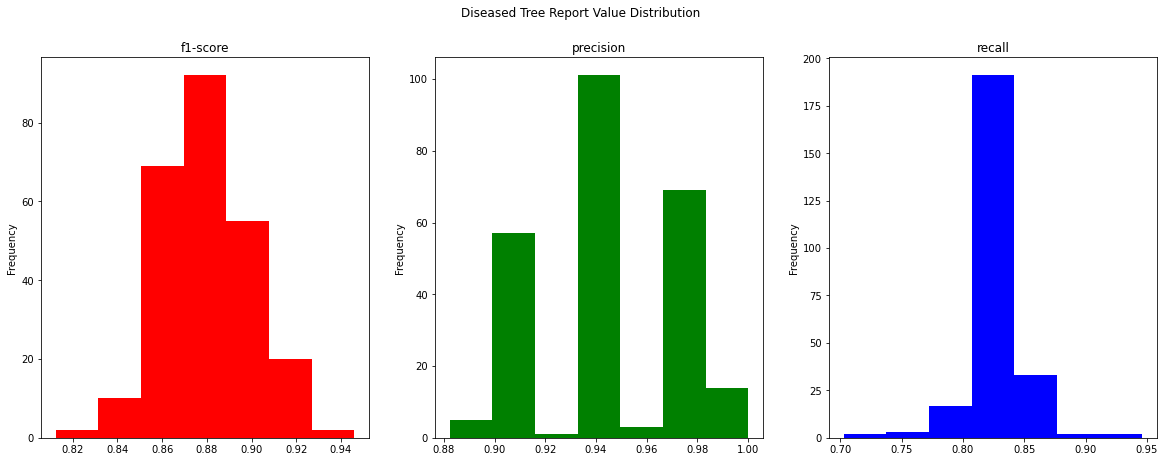

In [706]:
ranForTest6(250)

##### This took 43 seconds to run, a massive improvement over the baseline of 1 miute, 38 seconds.
##### Baseline medians: f1-score: 0.873      precision: 0.938    recall: 0.838
#### As of this markdown comment being written, the overall accuracy dipped below .99 11 times (vs 0), however, the median was .9890, the same as the baseline. As well, each of the median values for precission and recall were the same as the baseline. f1-score median dropped to .882, however, thats just as good as it was before we added min_samples_split. Going to see if we can improve on this time any more.

### Best run time (with good output): ranForTest6, runtime of 43 seconds with 250 iterations.

Now time to mess with max_depth. I'll set it to 6 to start.

In [226]:
def ranForTest7(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=40,criterion='entropy',min_samples_split=10,max_depth=6)
        clf.fit(XA_train,np.ravel(yA_train))
        yAv_pred = clf.predict(XA_valid)
        report= classification_report(yA_valid,yAv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy, n_estimators=40, min_samples_split=10,max_depth=6')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Entropy, n_estimators=40, min_samples_split=10,max_depth=6
Overall accuracy dipped below .99 248 times, median was 0.9821
Median values for diseased tree:
f1-score: 0.787      precision: 1.000    recall: 0.649


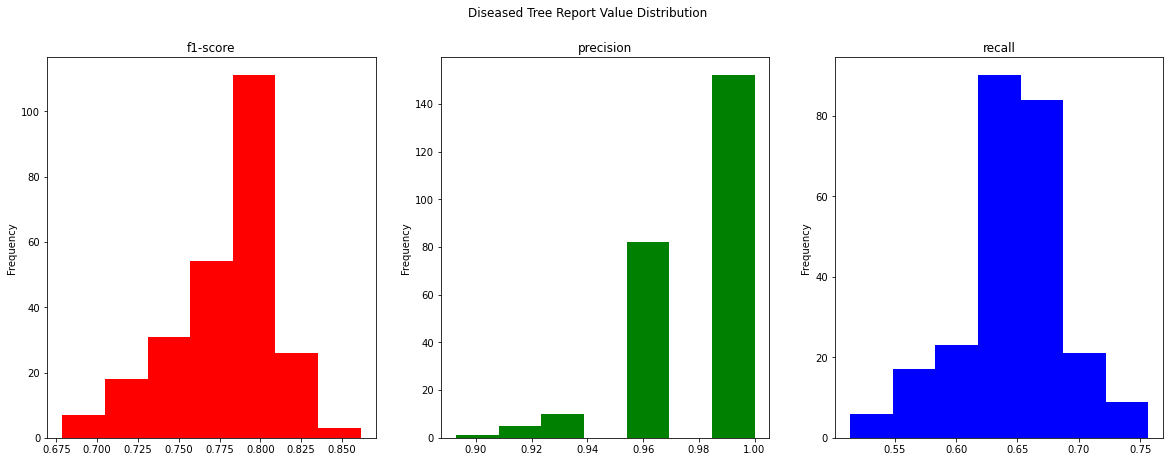

In [710]:
ranForTest7(250)

This one isn't even worth writing a mini-analysis on. It had a runtime of 39 seconds, slightly higher than the previous, and the output was much worse than we have previously seen, with even the median overall accuracy score being .9821 (and overall accuracy dipping below .99 248 times out of 250.) Going back to lowering n_estimators.

Going to lower n_estimators from 40 to 10.

In [227]:
def ranForTest8(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=10,criterion='entropy',min_samples_split=10)
        clf.fit(XA_train,np.ravel(yA_train))
        yAv_pred = clf.predict(XA_valid)
        report= classification_report(yA_valid,yAv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy, n_estimators=10, min_samples_split=10')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Entropy, n_estimators=10, min_samples_split=10
Overall accuracy dipped below .99 74 times, median was 0.9876
Median values for diseased tree:
f1-score: 0.863      precision: 0.935    recall: 0.811


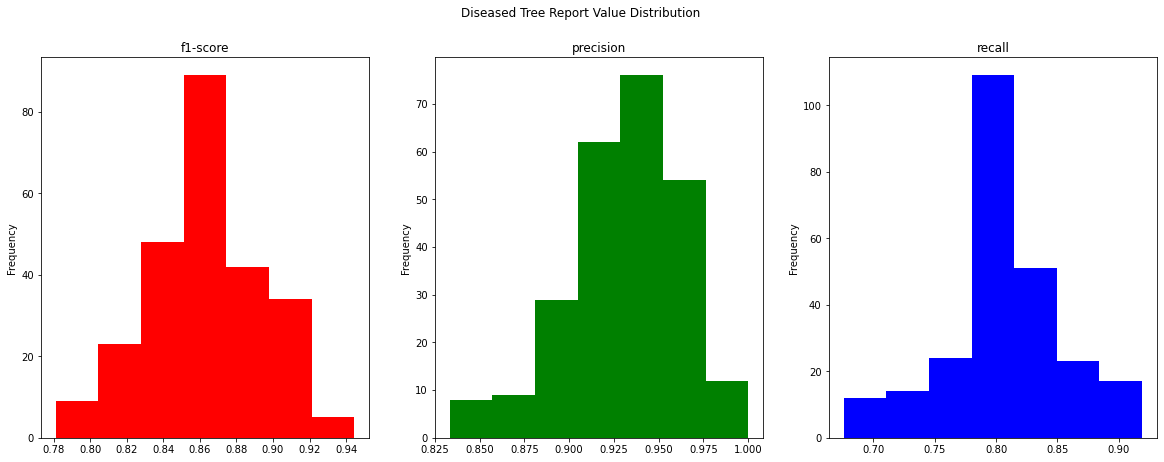

In [713]:
ranForTest8(250)

This one ran in 15 seconds for 250 iterations, a massive improvement over the previous best of 40 seconds! Overall accuracy dipped below .99 74 times, however, the median was .9876, which is not much lower than our baseline (.989). The median values for diseased tree dropped, but not by too much-- f1-score from .886 to .863, precision from .939 to .935, and recall from .838 to .811. I'm going to go ahead with this one-- it seems this model would be used to detect diseased trees across massive areas (presumably larger than the photo(s) the dataset was pulled from), like an entire national park, and you'd want it to run within a reasonable amount of time (especially since park rangers and environmentalists aren't known for having top of the line computers.)

Alright! Time to run the final test:

Going to choose random_state=1, just so the results stay the same:

In [228]:
clf = RandomForestClassifier(n_estimators=10,criterion='entropy',min_samples_split=10,random_state=1)
clf.fit(XA_train,np.ravel(yA_train))
yA_pred = clf.predict(XA_test)
print(classification_report(yA_test,yA_pred))

                      precision    recall  f1-score   support

all other land cover       0.98      1.00      0.99       682
       diseased tree       0.97      0.64      0.77        44

            accuracy                           0.98       726
           macro avg       0.97      0.82      0.88       726
        weighted avg       0.98      0.98      0.97       726



Text(0.5, 24.0, 'Predicted Label')

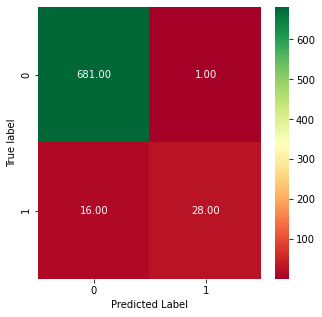

In [229]:
cm = confusion_matrix(yA_test, yA_pred)
fig = plt.figure(figsize=(5,5))
heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
plt.ylabel('True label')
plt.xlabel('Predicted Label')

Text(0.5, 51.0, 'Predicted Label')

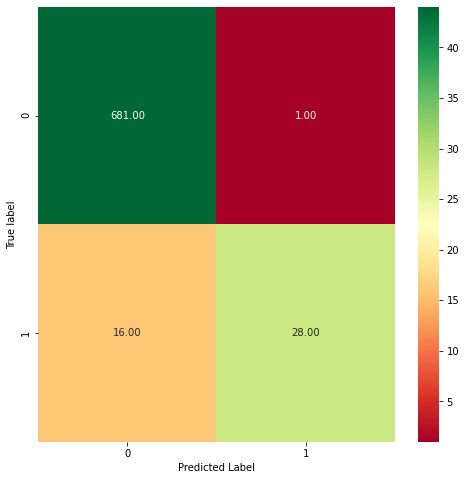

In [231]:
cm = confusion_matrix(yA_test, yA_pred)
fig = plt.figure(figsize=(8,8))
heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn',vmax=44)
plt.ylabel('True label')
plt.xlabel('Predicted Label')

Oof. That didn't work out so well. 

## Now going to do this with dfB (except with 100 iterations each instead of 250, as I want things to go by faster)

In [232]:
yB=dfB.sick
XB=dfB.iloc[:,1:]
XB_train, XB_temp, yB_train, yB_temp = train_test_split(XB,yB, test_size=.30, random_state=16)
XB_test, XB_valid, yB_test, yB_valid = train_test_split(XB_temp,yB_temp, test_size=.50, random_state=61)

In [233]:
yB_train.groupby(yB_train).count()

sick
all other land cover    3011
diseased tree            179
Name: sick, dtype: int64

In [234]:
yB_valid.groupby(yB_valid).count()

sick
all other land cover    644
diseased tree            40
Name: sick, dtype: int64

In [235]:
yB_test.groupby(yB_test).count()

sick
all other land cover    642
diseased tree            42
Name: sick, dtype: int64

In [236]:
yB_train.shape
yB_test.shape
yB_valid.shape

(684,)

Now to begin messing with different aspects of the model. Going to use n_estimators=100, criterion='gini' as the baseline (as those are the default values for those parameters)-- anything better than that will replace it as the baseline until we give up.

In [237]:
clf = RandomForestClassifier(n_estimators=100,criterion='gini')
clf.fit(XB_train,np.ravel(yB_train))
yBv_pred = clf.predict(XB_valid)
print(classification_report(yB_valid,yBv_pred))

                      precision    recall  f1-score   support

all other land cover       0.98      0.99      0.99       644
       diseased tree       0.87      0.68      0.76        40

            accuracy                           0.98       684
           macro avg       0.93      0.83      0.87       684
        weighted avg       0.97      0.98      0.97       684



Text(0.5, 24.0, 'Predicted Label')

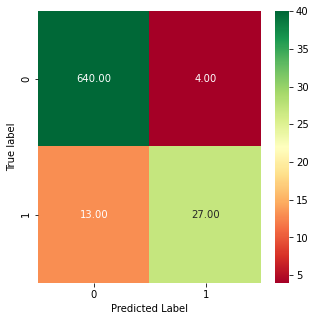

In [238]:
cm = confusion_matrix(yB_valid, yBv_pred)
fig = plt.figure(figsize=(5,5))
heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn',vmax=40)
plt.ylabel('True label')
plt.xlabel('Predicted Label')

In [239]:
def ranForTest1B(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='gini')
        clf.fit(XB_train,np.ravel(yB_train))
        yBv_pred = clf.predict(XB_valid)
        report= classification_report(yB_valid,yBv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Gini')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Testing it out:

Gini
Overall accuracy dipped below .99 100 times, median was 0.9751
Median values for diseased tree:
f1-score: 0.767      precision: 0.853    recall: 0.700


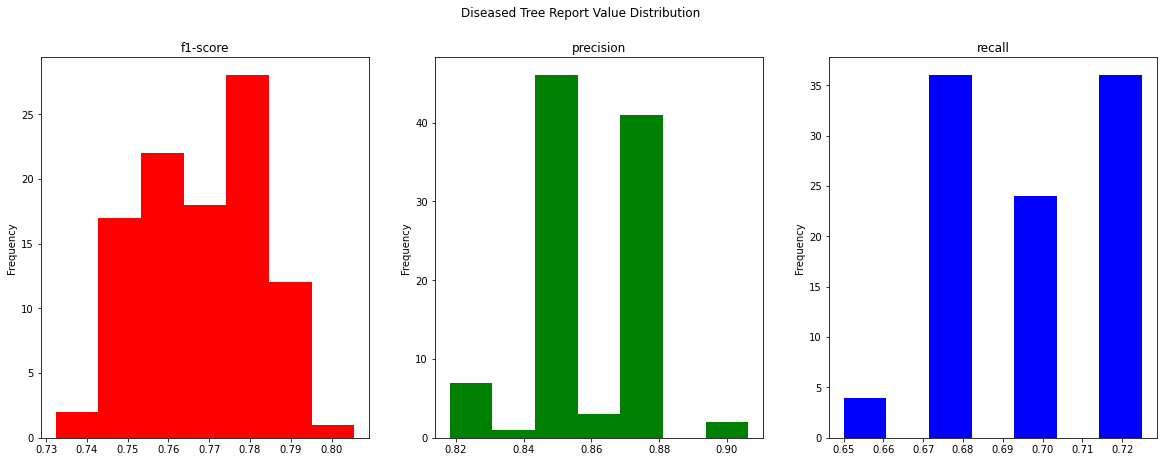

In [745]:
ranForTest1B(100)

We really want recall to be much higher than this (as of writing, median recall was at .7). Have to make this better.

Going to test out criterion='entropy', first just by looking at a random classification report, then via a modified version of the function.

In [747]:
def ranForTest2B(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='entropy')
        clf.fit(XB_train,np.ravel(yB_train))
        yBv_pred = clf.predict(XB_valid)
        report= classification_report(yB_valid,yBv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Entropy
Overall accuracy dipped below .99 100 times, median was 0.9751
Median values for diseased tree:
f1-score: 0.773      precision: 0.848    recall: 0.725


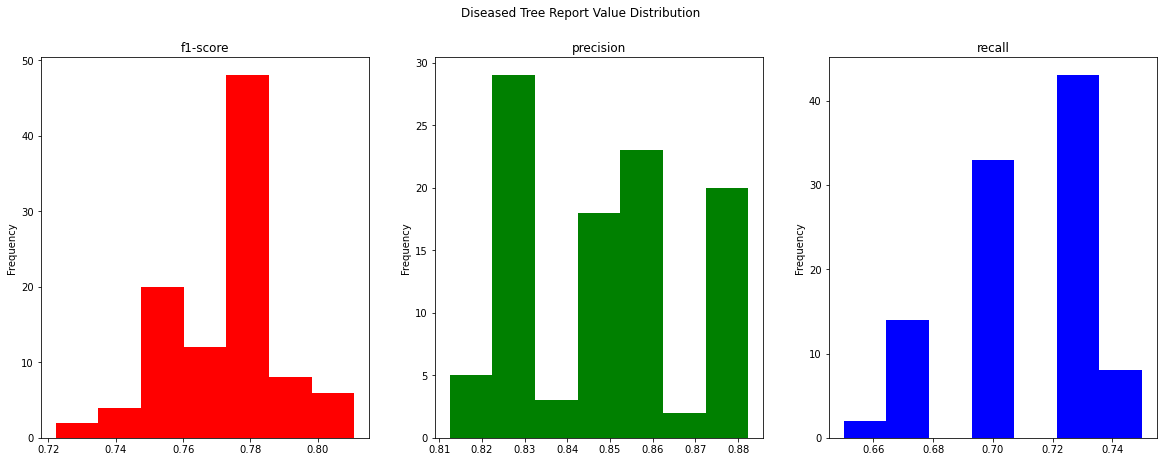

In [763]:
ranForTest2B(100)

Median recall here was .725, which is better, if not by much. Going to try some other parameters.

In [754]:
def ranForTest3B(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='entropy',class_weight='balanced')
        clf.fit(XB_train,np.ravel(yB_train))
        yBv_pred = clf.predict(XB_valid)
        report= classification_report(yB_valid,yBv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy, class_weight=balanced')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Entropy, class_weight=balanced
Overall accuracy dipped below .99 100 times, median was 0.9751
Median values for diseased tree:
f1-score: 0.767      precision: 0.831    recall: 0.700


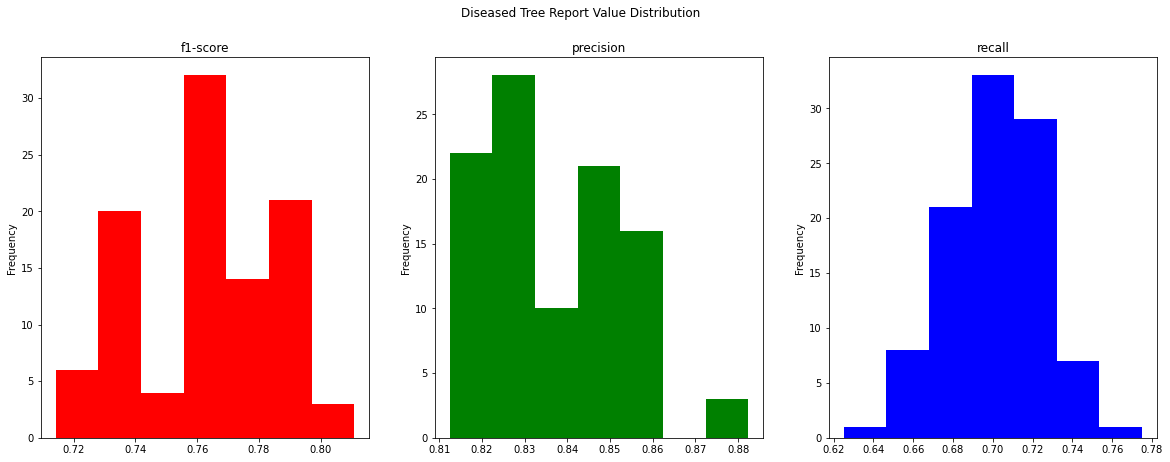

In [755]:
ranForTest3B(100)

No improvement.

In [759]:
def ranForTest4B(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='entropy',class_weight='balanced_subsample')
        clf.fit(XB_train,np.ravel(yB_train))
        yBv_pred = clf.predict(XB_valid)
        report= classification_report(yB_valid,yBv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy, class_weight=balanced_subset')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Entropy, class_weight=balanced_subset
Overall accuracy dipped below .99 100 times, median was 0.9737
Median values for diseased tree:
f1-score: 0.757      precision: 0.844    recall: 0.700


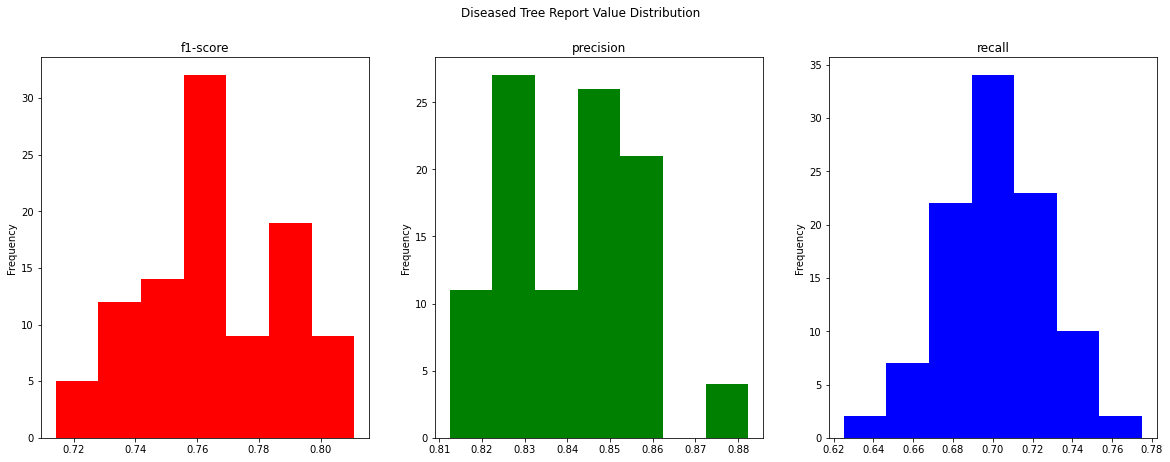

In [760]:
ranForTest4B(100)

Still no improvement.

In [761]:
def ranForTest5B(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='entropy',min_samples_leaf=5)
        clf.fit(XB_train,np.ravel(yB_train))
        yBv_pred = clf.predict(XB_valid)
        report= classification_report(yB_valid,yBv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy, min_samples_leaf=5')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Entropy, min_samples_leaf=5
Overall accuracy dipped below .99 100 times, median was 0.9766
Median values for diseased tree:
f1-score: 0.778      precision: 0.871    recall: 0.700


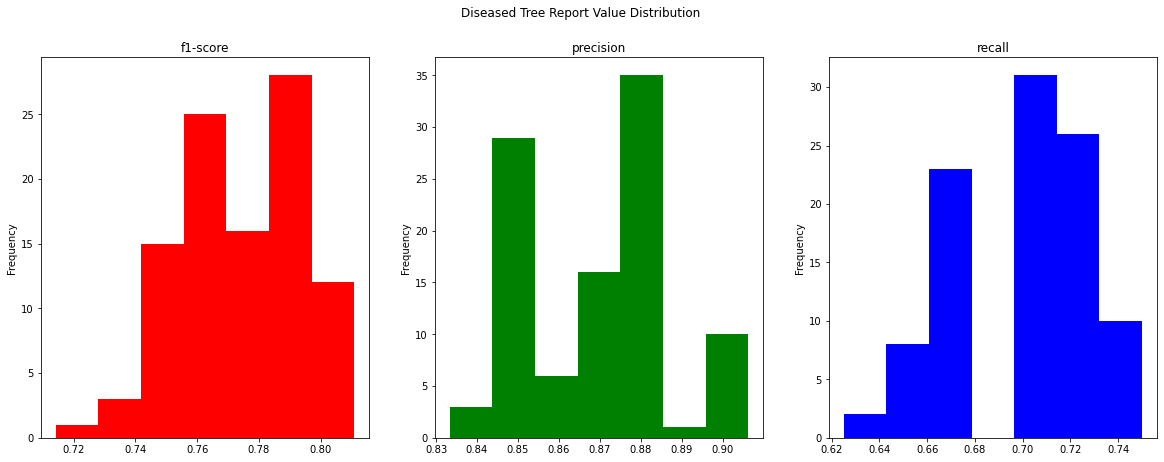

In [762]:
ranForTest5B(100)

And, as from before, no improvement. Going to go ahead and run the test for 2B, which had the best recall thus far. It was n_estimators=100, criterion=entropy. Going to set random_state=1, just so the results stay the same.

In [766]:
clf = RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=1)
clf.fit(XB_train,np.ravel(yB_train))
yB_pred = clf.predict(XB_test)
print(classification_report(yB_test,yB_pred))

                      precision    recall  f1-score   support

all other land cover       0.98      1.00      0.99       642
       diseased tree       0.94      0.74      0.83        42

            accuracy                           0.98       684
           macro avg       0.96      0.87      0.91       684
        weighted avg       0.98      0.98      0.98       684



Text(0.5, 24.0, 'Predicted Label')

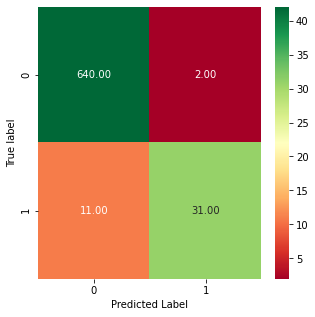

In [770]:
cm = confusion_matrix(yB_test, yB_pred)
fig = plt.figure(figsize=(5,5))
heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn',vmax=42)
plt.ylabel('True label')
plt.xlabel('Predicted Label')

## Going to do one more test: using dfA with normalized data, 80/10/10 split.

In [790]:
yA=dfA.sick
XA=dfA.iloc[:,1:]
XAn=(XA-XA.min())/(XA.max()-XA.min())
XA_train, XA_temp, yA_train, yA_temp = train_test_split(XAn,yA, test_size=.20, random_state=70)
XA_test, XA_valid, yA_test, yA_valid = train_test_split(XA_temp,yA_temp, test_size=.50, random_state=100)

In [791]:
yA_train.groupby(yA_train).count()

sick
all other land cover    3658
diseased tree            212
Name: sick, dtype: int64

In [792]:
yA_valid.groupby(yA_valid).count()

sick
all other land cover    456
diseased tree            28
Name: sick, dtype: int64

In [793]:
yA_test.groupby(yA_test).count()

sick
all other land cover    463
diseased tree            21
Name: sick, dtype: int64

In [794]:
yA_train.shape
yA_test.shape
yA_valid.shape

(484,)

Now to begin messing with different aspects of the model. Going to use n_estimators=100, criterion='gini' as the baseline (as those are the default values for those parameters)-- anything better than that will replace it as the baseline until we give up.

In [796]:
clf = RandomForestClassifier(n_estimators=100,criterion='gini')
clf.fit(XA_train,np.ravel(yA_train))
yAv_pred = clf.predict(XA_valid)
print(classification_report(yA_valid,yAv_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      1.00      0.99       456
       diseased tree       0.96      0.82      0.88        28

            accuracy                           0.99       484
           macro avg       0.97      0.91      0.94       484
        weighted avg       0.99      0.99      0.99       484



Text(0.5, 24.0, 'Predicted Label')

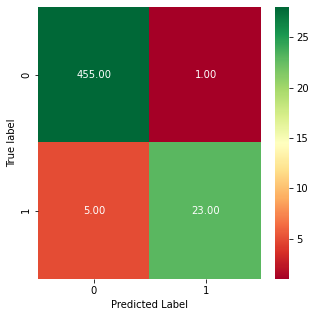

In [797]:
cm = confusion_matrix(yA_valid, yAv_pred)
fig = plt.figure(figsize=(5,5))
heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn',vmax=28)
plt.ylabel('True label')
plt.xlabel('Predicted Label')

In [798]:
def ranForTest1N(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='gini')
        clf.fit(XA_train,np.ravel(yA_train))
        yAv_pred = clf.predict(XA_valid)
        report= classification_report(yA_valid,yAv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Gini')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])

Gini
Overall accuracy dipped below .99 71 times, median was 0.9835
Median values for diseased tree:
f1-score: 0.840      precision: 0.955    recall: 0.750


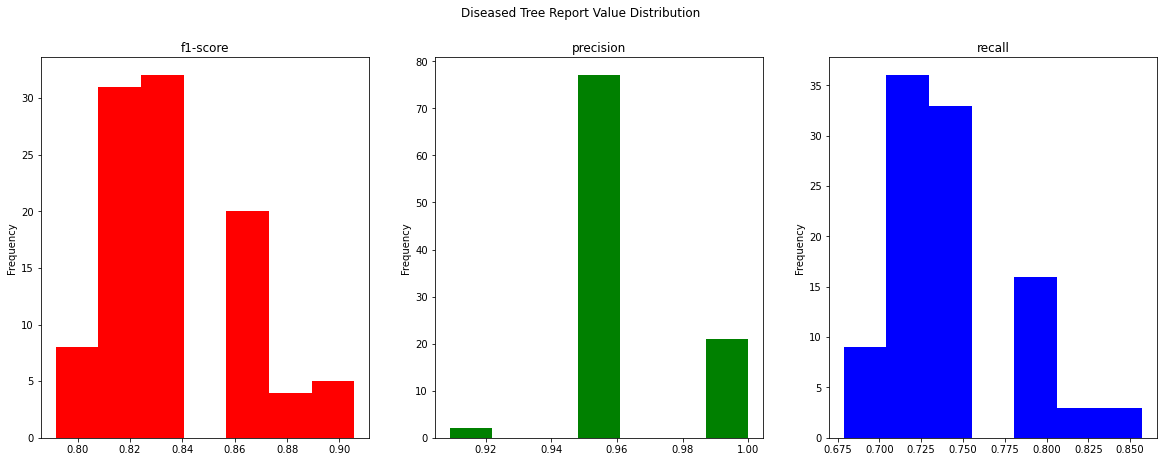

In [799]:
ranForTest1N(100)

Entropy
Overall accuracy dipped below .99 35 times, median was 0.9855
Median values for diseased tree:
f1-score: 0.857      precision: 1.000    recall: 0.750


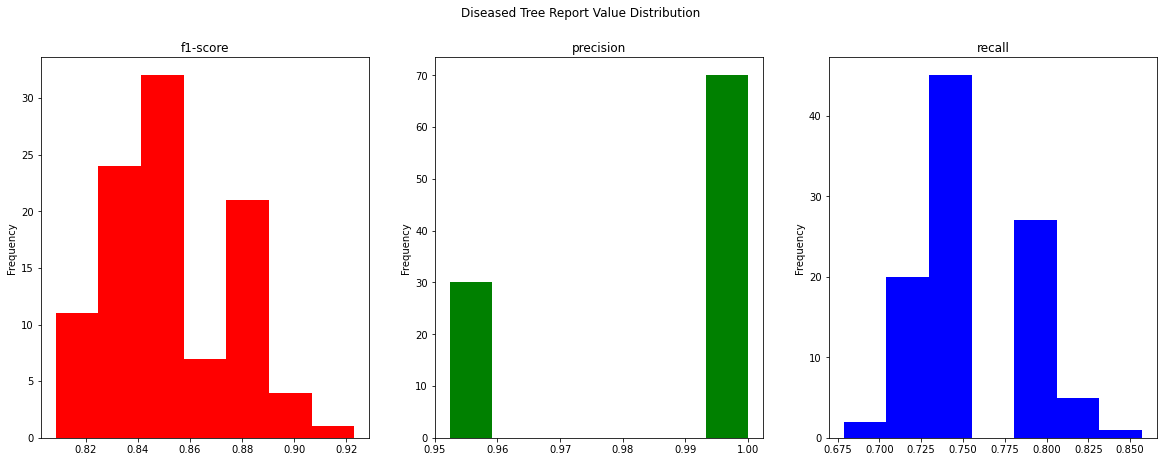

In [800]:
def ranForTest2N(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='entropy')
        clf.fit(XA_train,np.ravel(yA_train))
        yAv_pred = clf.predict(XA_valid)
        report= classification_report(yA_valid,yAv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])
ranForTest2N(100)

Entropy,min_samples_split=6
Overall accuracy dipped below .99 45 times, median was 0.9855
Median values for diseased tree:
f1-score: 0.857      precision: 1.000    recall: 0.750


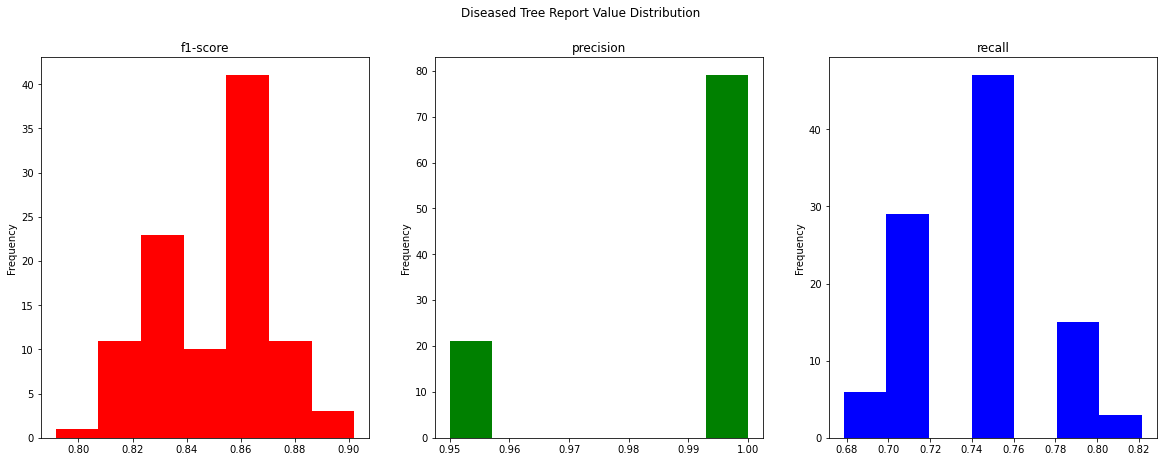

In [801]:
def ranForTest3N(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='entropy',min_samples_split=6)
        clf.fit(XA_train,np.ravel(yA_train))
        yAv_pred = clf.predict(XA_valid)
        report= classification_report(yA_valid,yAv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy,min_samples_split=6')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])
ranForTest3N(100)

This one was slightly worse than previous.

Entropy,min_samples_leaf=5
Overall accuracy dipped below .99 85 times, median was 0.9835
Median values for diseased tree:
f1-score: 0.833      precision: 1.000    recall: 0.714


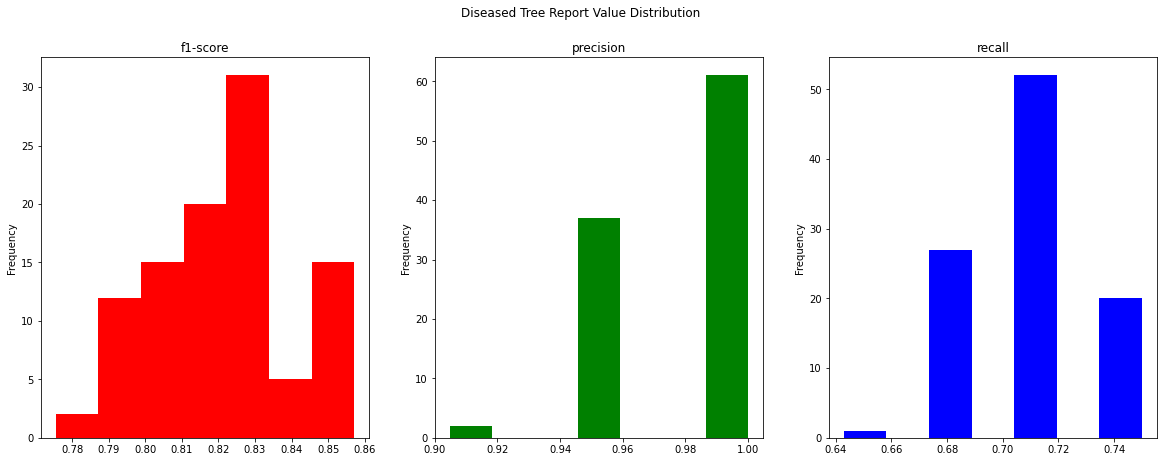

In [803]:
def ranForTest4N(numberOfTimesToRun):
    #First, going to define the dataframe that will hold the values we want.
    tempdict={'overallAcc':[], 'df1':[], 'dpre':[],'drec':[]}
    df = pd.DataFrame(tempdict)
    for n in range(numberOfTimesToRun):
        clf = RandomForestClassifier(n_estimators=100,criterion='entropy',min_samples_leaf=5)
        clf.fit(XA_train,np.ravel(yA_train))
        yAv_pred = clf.predict(XA_valid)
        report= classification_report(yA_valid,yAv_pred,output_dict=True) #saving dictionary to variable
        df.loc[len(df.index)] = [report['accuracy'], report['diseased tree']['f1-score'],report['diseased tree']['precision'],report['diseased tree']['recall']] #adding row
    dippedBelow=len(df.query('overallAcc<=.985'))
    print('Entropy,min_samples_leaf=5')
    print(f'Overall accuracy dipped below .99 {dippedBelow} times, median was {df.overallAcc.median():.4f}')
    print(f'Median values for diseased tree:')
    print(f'f1-score: {df.df1.median():.3f}      precision: {df.dpre.median():.3f}    recall: {df.drec.median():.3f}')
    fig, axes = plt.subplots(1,3, figsize=(20,7))
    fig.suptitle('Diseased Tree Report Value Distribution')
    df.df1.plot(kind='hist',title='f1-score',color='red',bins=7,legend=False,ax=axes[0])
    df.dpre.plot(kind='hist',title='precision',color='green',bins=7,legend=False,ax=axes[1])
    df.drec.plot(kind='hist',title='recall',color='blue',bins=7,legend=False,ax=axes[2])
ranForTest4N(100)

Best I've gotten so far was 2N, criterion='entropy'. Going to test that now.

In [806]:
clf = RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=1)
clf.fit(XA_train,np.ravel(yA_train))
yA_pred = clf.predict(XA_test)
print(classification_report(yA_test,yA_pred))

                      precision    recall  f1-score   support

all other land cover       0.99      1.00      1.00       463
       diseased tree       0.95      0.86      0.90        21

            accuracy                           0.99       484
           macro avg       0.97      0.93      0.95       484
        weighted avg       0.99      0.99      0.99       484



Text(0.5, 24.0, 'Predicted Label')

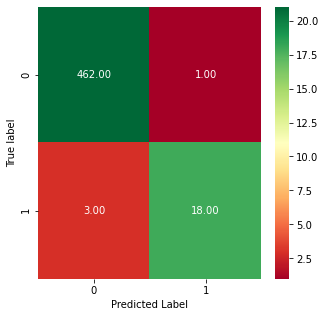

In [807]:
cm = confusion_matrix(yA_test, yA_pred)
fig = plt.figure(figsize=(5,5))
heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn',vmax=21)
plt.ylabel('True label')
plt.xlabel('Predicted Label')

### End of Notebook